In [1]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from scipy.integrate import cumulative_trapezoid
from astropy.coordinates import SkyCoord
from scipy.ndimage import gaussian_filter
import seaborn as sns

import sys
sys.path.append('../src')
import plotting, helpers
from importlib import reload

%config InlineBackend.figure_format = 'retina'


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.7*fs,
          'legend.title_fontsize': 0.8*fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:193: GalaFutureWarning: In a future version of Gala, the current MilkyWayPotential and MilkyWayPotential2022 classes will be combined into a single class, MilkyWayPotential, with an optional 'version' argument to select between the models. To use the old (version 1) MilkyWayPotential, specify version="v1" when creating an instance. To use the newer (version 2 = current MilkyWayPotential2022), specify version="v2".
  warnings.warn(
/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(


In [15]:
pop = cogsworth.pop.load("/mnt/ceph/users/twagg/underworld/binaries", parts=[])
pop.bpp["row_num"] = np.arange(len(pop.bpp))
pop.colour = "tab:blue"
pop.label = "Fiducial"

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(


# Rates

In [16]:
scale_up = 6e10 / pop.mass_binaries
scale_up

np.float64(3307.606976577281)

In [17]:
n_ns = (pop.final_bpp["kstar_1"] == 13).sum() + (pop.final_bpp["kstar_2"] == 13).sum()
n_bh = (pop.final_bpp["kstar_1"] == 14).sum() + (pop.final_bpp["kstar_2"] == 14).sum()
print(f"Rates (unscaled)\n  Total: {n_ns + n_bh}, NSs: {n_ns}, BHs: {n_bh}")
print(f"Rates (scaled)\n  Total: {(n_ns + n_bh) * scale_up:.1e}, NSs: {n_ns * scale_up:.1e}, BHs: {n_bh * scale_up:.1e}")

Rates (unscaled)
  Total: 200093, NSs: 144806, BHs: 55287
Rates (scaled)
  Total: 6.6e+08, NSs: 4.8e+08, BHs: 1.8e+08


Olejak+20 predicted 1.2e8 BHs, close!

# Spatial distributions

In [29]:
kinematics = helpers.get_kinematics([pop])
stars = cogsworth.sfh.SandersBinney2015(
    size=200000,
    **{
        "potential": pop.galactic_potential,
        "time_bins": 5,
        "verbose": True
    }
)

Pre-computing lookback time, guiding radius and frequency interpolations
Initiating sampling procedure
  Sampling 161686 stars from the thin_disc
    Sampling 19412 stars with lookback times between 0.00 Gyr and 2.00 Gyr
    Sampling 24539 stars with lookback times between 2.00 Gyr and 4.00 Gyr
    Sampling 31589 stars with lookback times between 4.00 Gyr and 6.00 Gyr
    Sampling 38858 stars with lookback times between 6.00 Gyr and 8.00 Gyr
    Sampling 47288 stars with lookback times between 8.00 Gyr and 10.00 Gyr
  Sampling 38314 stars from the thick_disc
    Sampling 38314 stars with lookback times between 10.00 Gyr and 12.00 Gyr


[ 29.77685954 219.84188486]
[ 5948.4241494  10411.45391119]


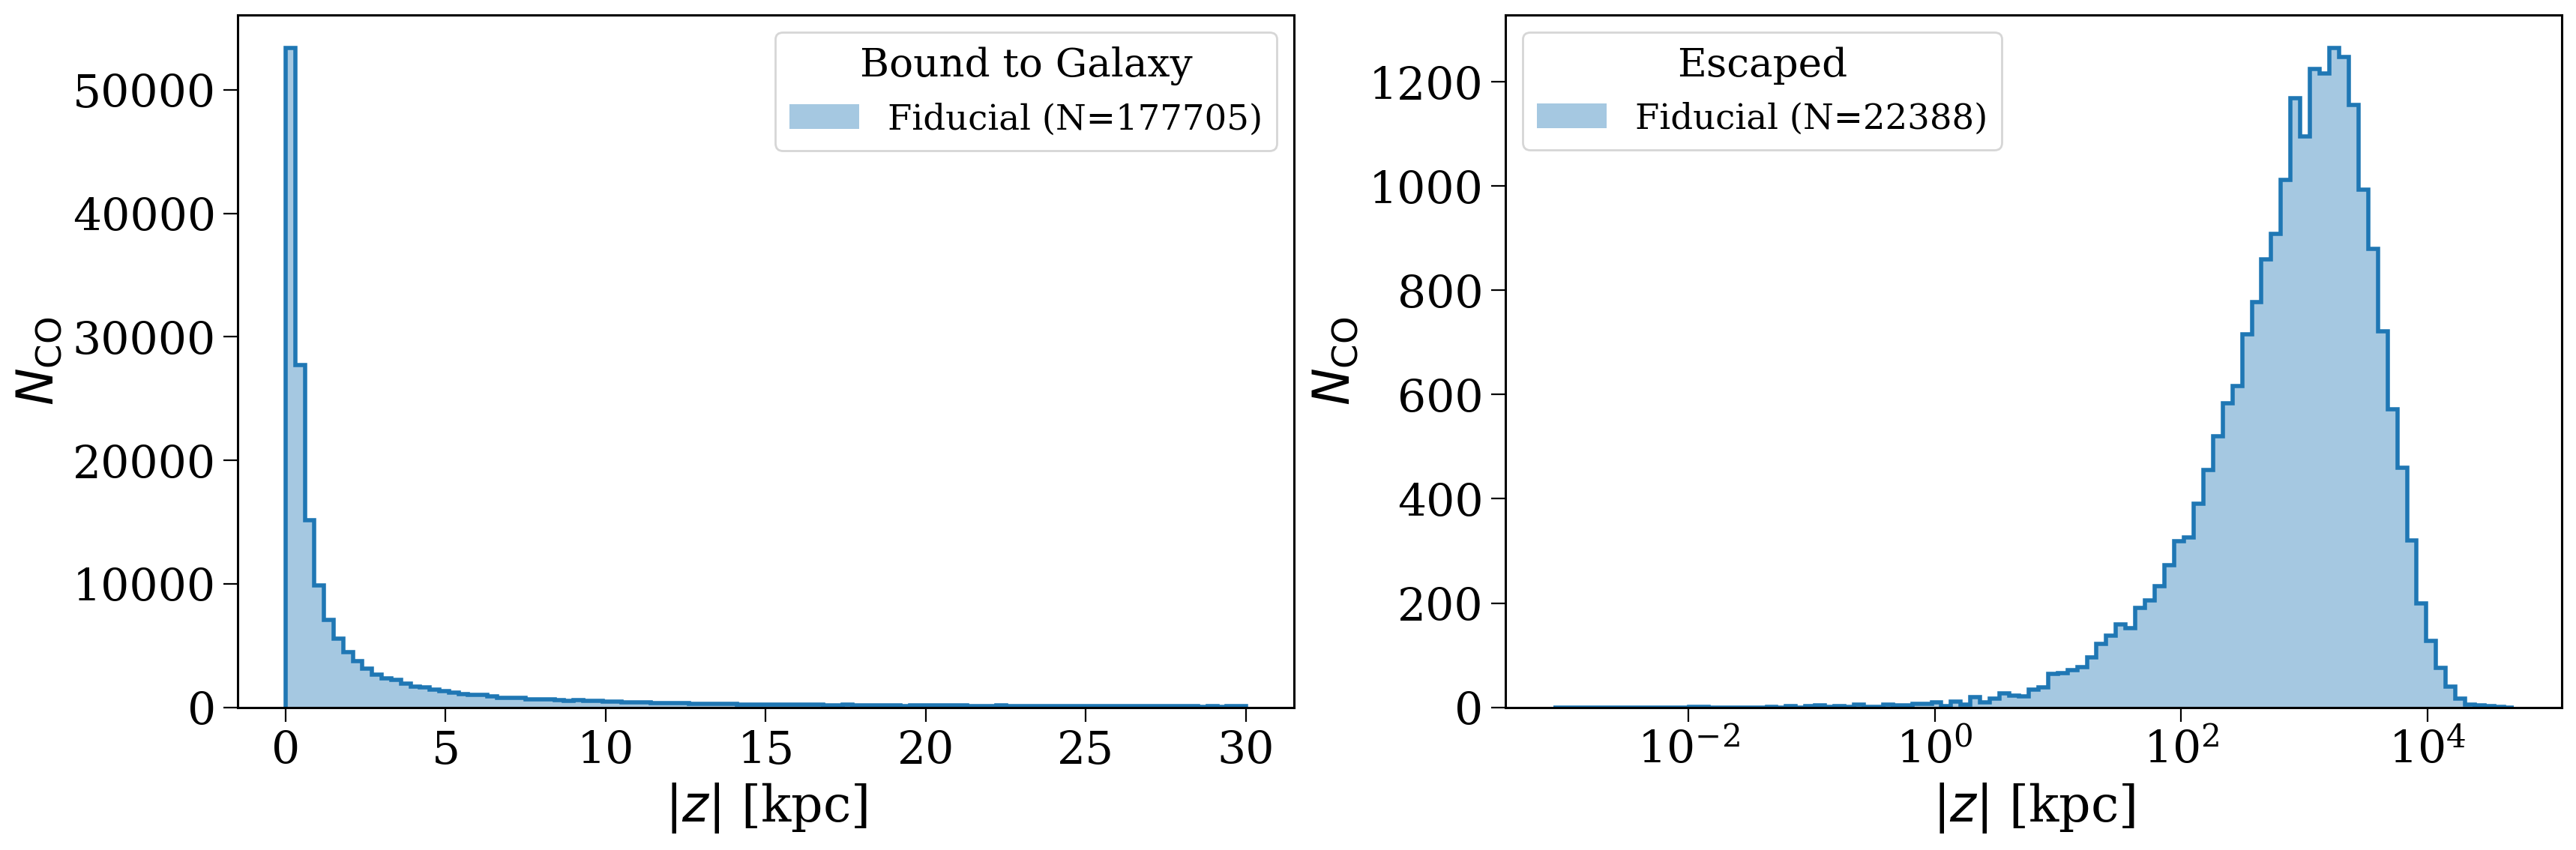

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

scales = ['linear', 'log']
bin_list = [np.linspace(0, 30, 101), np.geomspace(8e-4, 5e4, 100)]
labels = ['Bound to Galaxy', "Escaped"]

for ax, scale, bins, label in zip(axes, scales, bin_list, labels):
    co_pos = kinematics[pop.label]["pos"]["CO"]
    co_vel = kinematics[pop.label]["vel"]["CO"]

    co_V = np.linalg.norm(co_vel.to(u.km/u.s).value, axis=1)

    mask = co_V >= np.sqrt(-2 * pop.galactic_potential(co_pos.T)).to(u.km / u.s).value
    mask = mask if label == "Escaped" else ~mask

    print(np.percentile(np.abs(co_pos[:, 2].to(u.kpc).value)[mask], [95, 99]))

    ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value)[mask], bins=bins, histtype='step', lw=2, color=pop.colour)
    ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value)[mask], bins=bins, alpha=0.4, color=pop.colour,
            label=f'{pop.label} (N={len(co_pos[mask])})')

    ax.set(
        xscale=scale,
        xlabel=r'$|z|$ [kpc]',
        ylabel=r'$N_{\rm CO}$',
    )
    ax.legend(title=label)
plt.show()

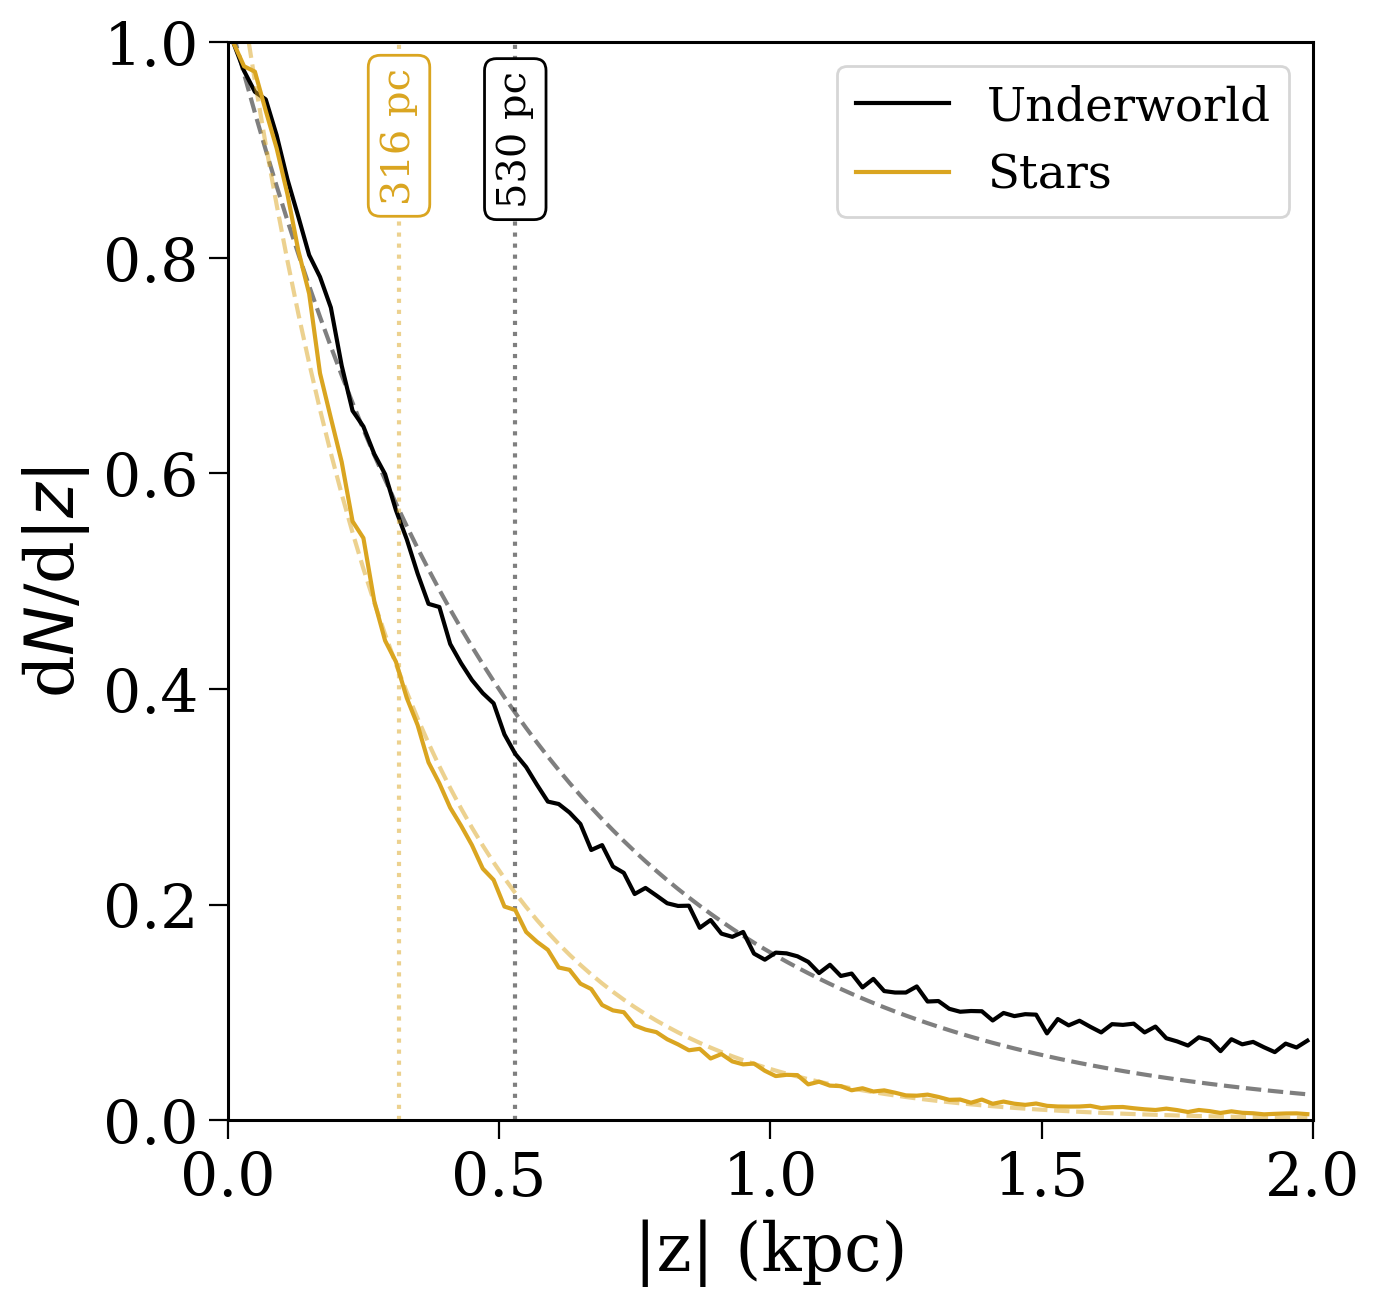

In [142]:
fig, ax = plt.subplots(figsize=(7, 7))

reload(plotting)

for z, label, colour in zip(
    [kinematics["Fiducial"]["pos"]["CO"][:, 2], stars.z],
    ["Underworld", "Stars"],
    ["black", "goldenrod"]
):
    scale_height, _, _ = plotting.estimate_scale_height(
        z=z,
        plot=True,
        label=label,
        colour=colour,
        show=False,
        fig=fig,
        ax=ax,
        xlim=(0, 2),
        ylim=(0, 1)
    )

plt.savefig("../plots/scale_height_underworld_vs_stars.pdf", format="pdf", bbox_inches='tight')
plt.show()

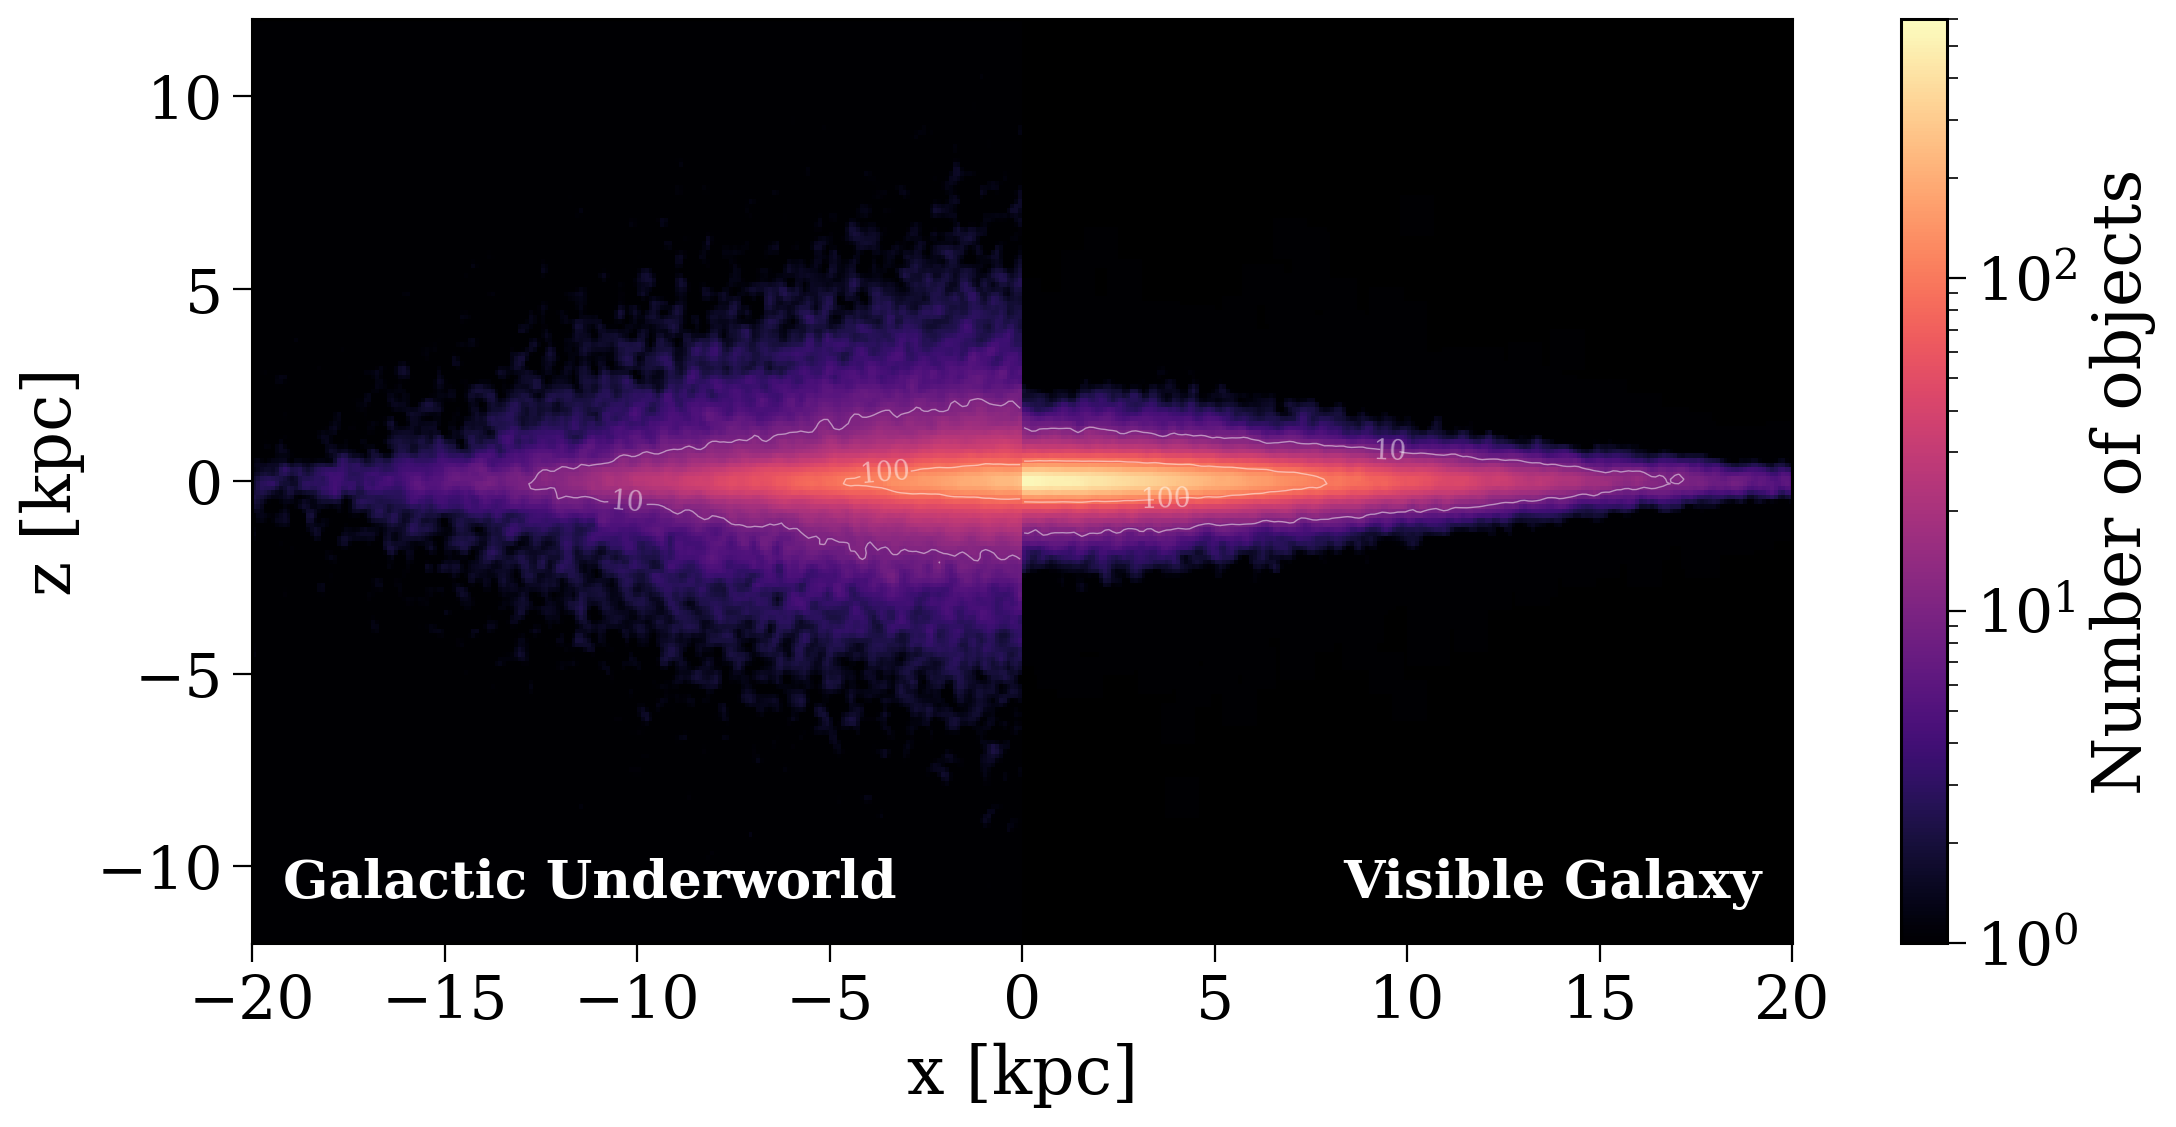

In [38]:
reload(plotting)
fig, ax = plotting.plot_side_on_density(
    xs=[stars.x, kinematics["Fiducial"]["pos"]["CO"][:, 0]],
    zs=[stars.z, kinematics["Fiducial"]["pos"]["CO"][:, 2]],
    labels=["Galactic Underworld", "Visible Galaxy"],
    xlim=20,
    zlim=12,
    n_bins=200,
    sigma=1.0,
    contours=[10, 100],
    apply_smoothing=True,
    show=False
)

plt.savefig("../plots/density_stars_vs_underworld.pdf", format="pdf", bbox_inches='tight')
plt.show()

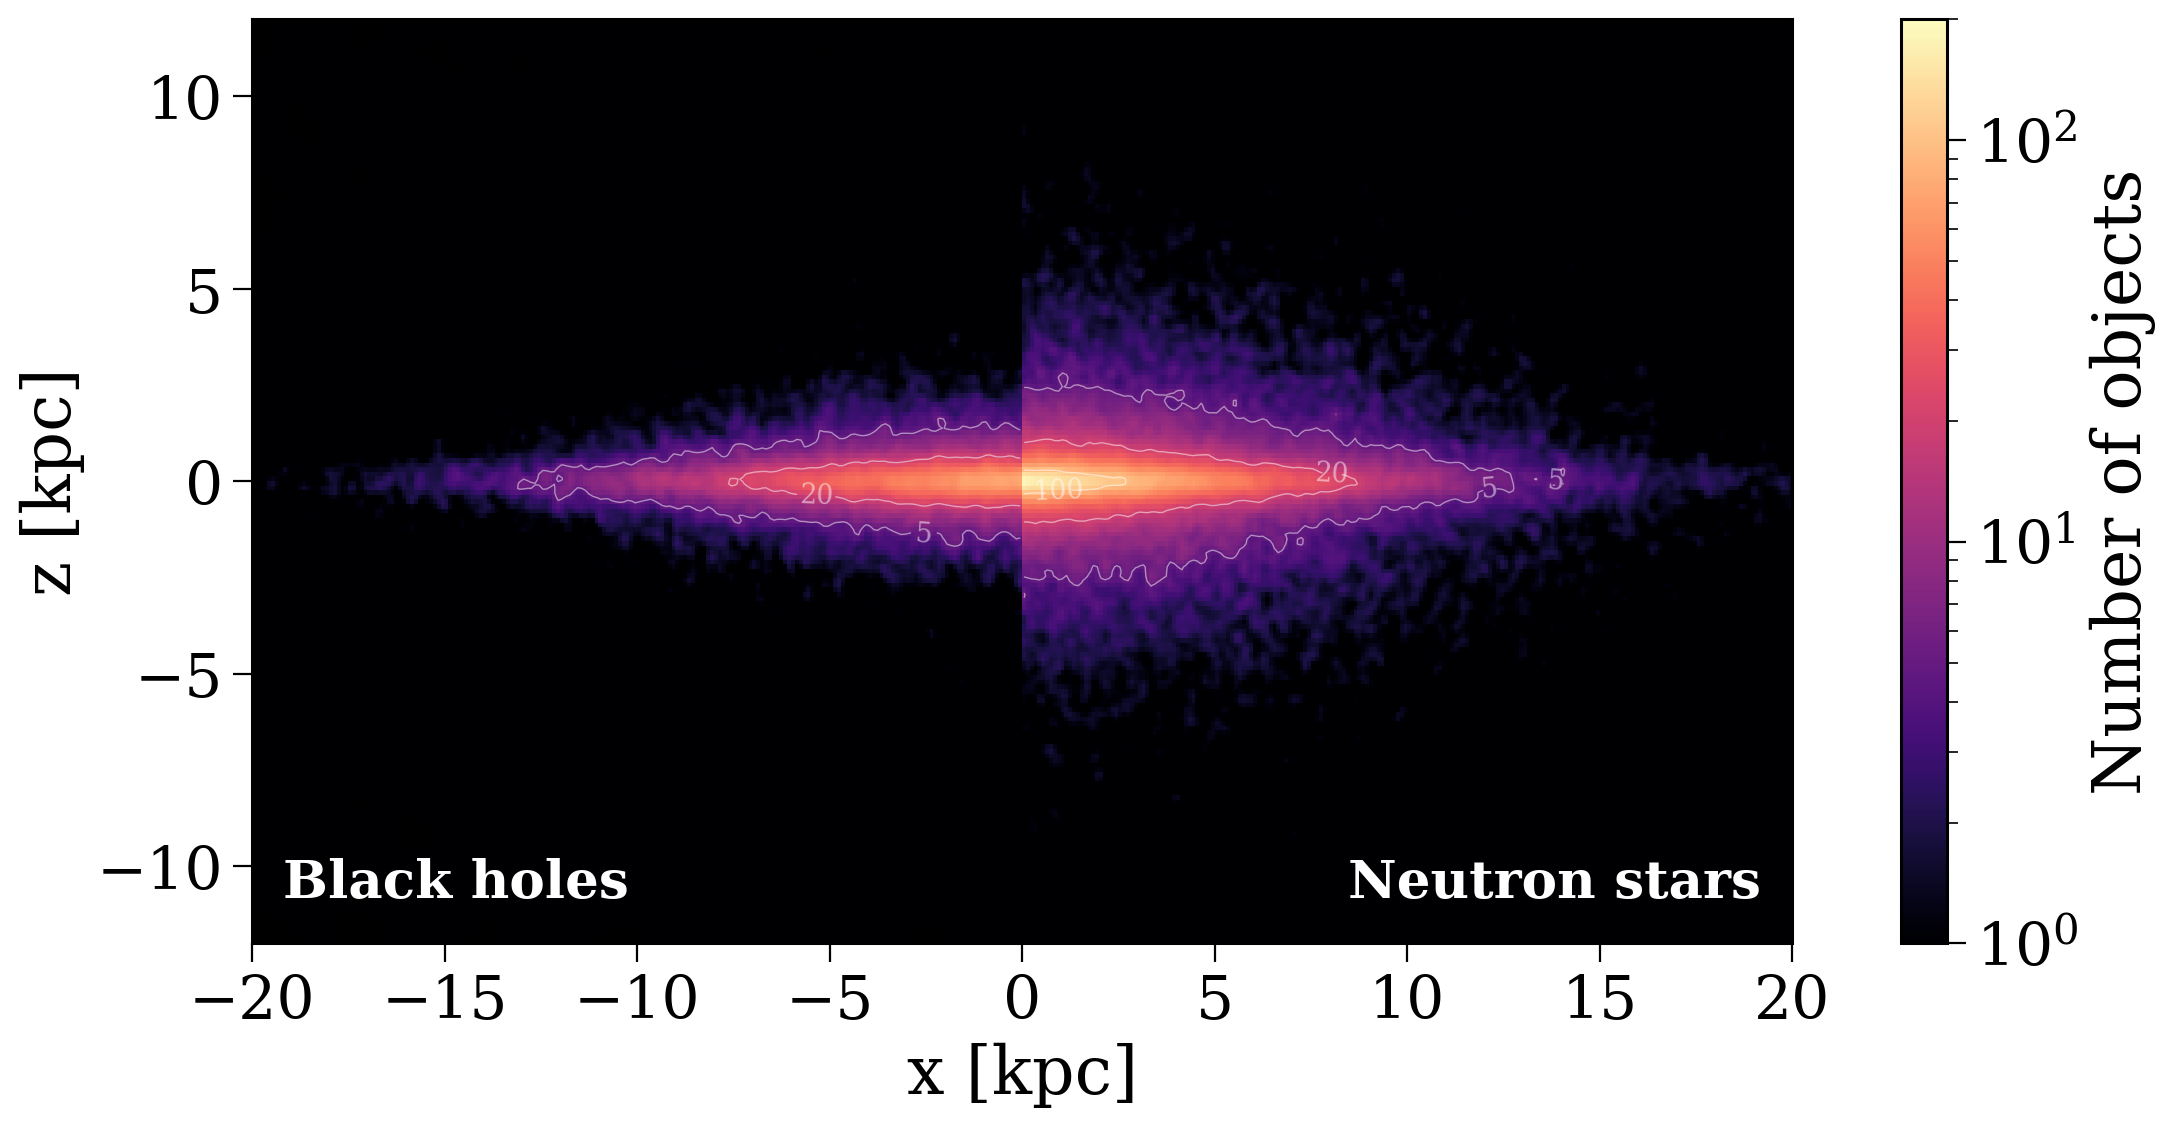

In [128]:
reload(plotting)
plotting.plot_side_on_density(
    xs=[kinematics["Fiducial"]["pos"]["NS"][:, 0], kinematics["Fiducial"]["pos"]["BH"][:, 0]],
    zs=[kinematics["Fiducial"]["pos"]["NS"][:, 2], kinematics["Fiducial"]["pos"]["BH"][:, 2]],
    labels=["Black holes", "Neutron stars"],
    xlim=20,
    zlim=12,
    n_bins=200,
    sigma=1.0,
    contours=[5, 20, 100],
    apply_smoothing=True,
    show=False
)

plt.savefig("../plots/density_bh_vs_ns.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Mass distributions

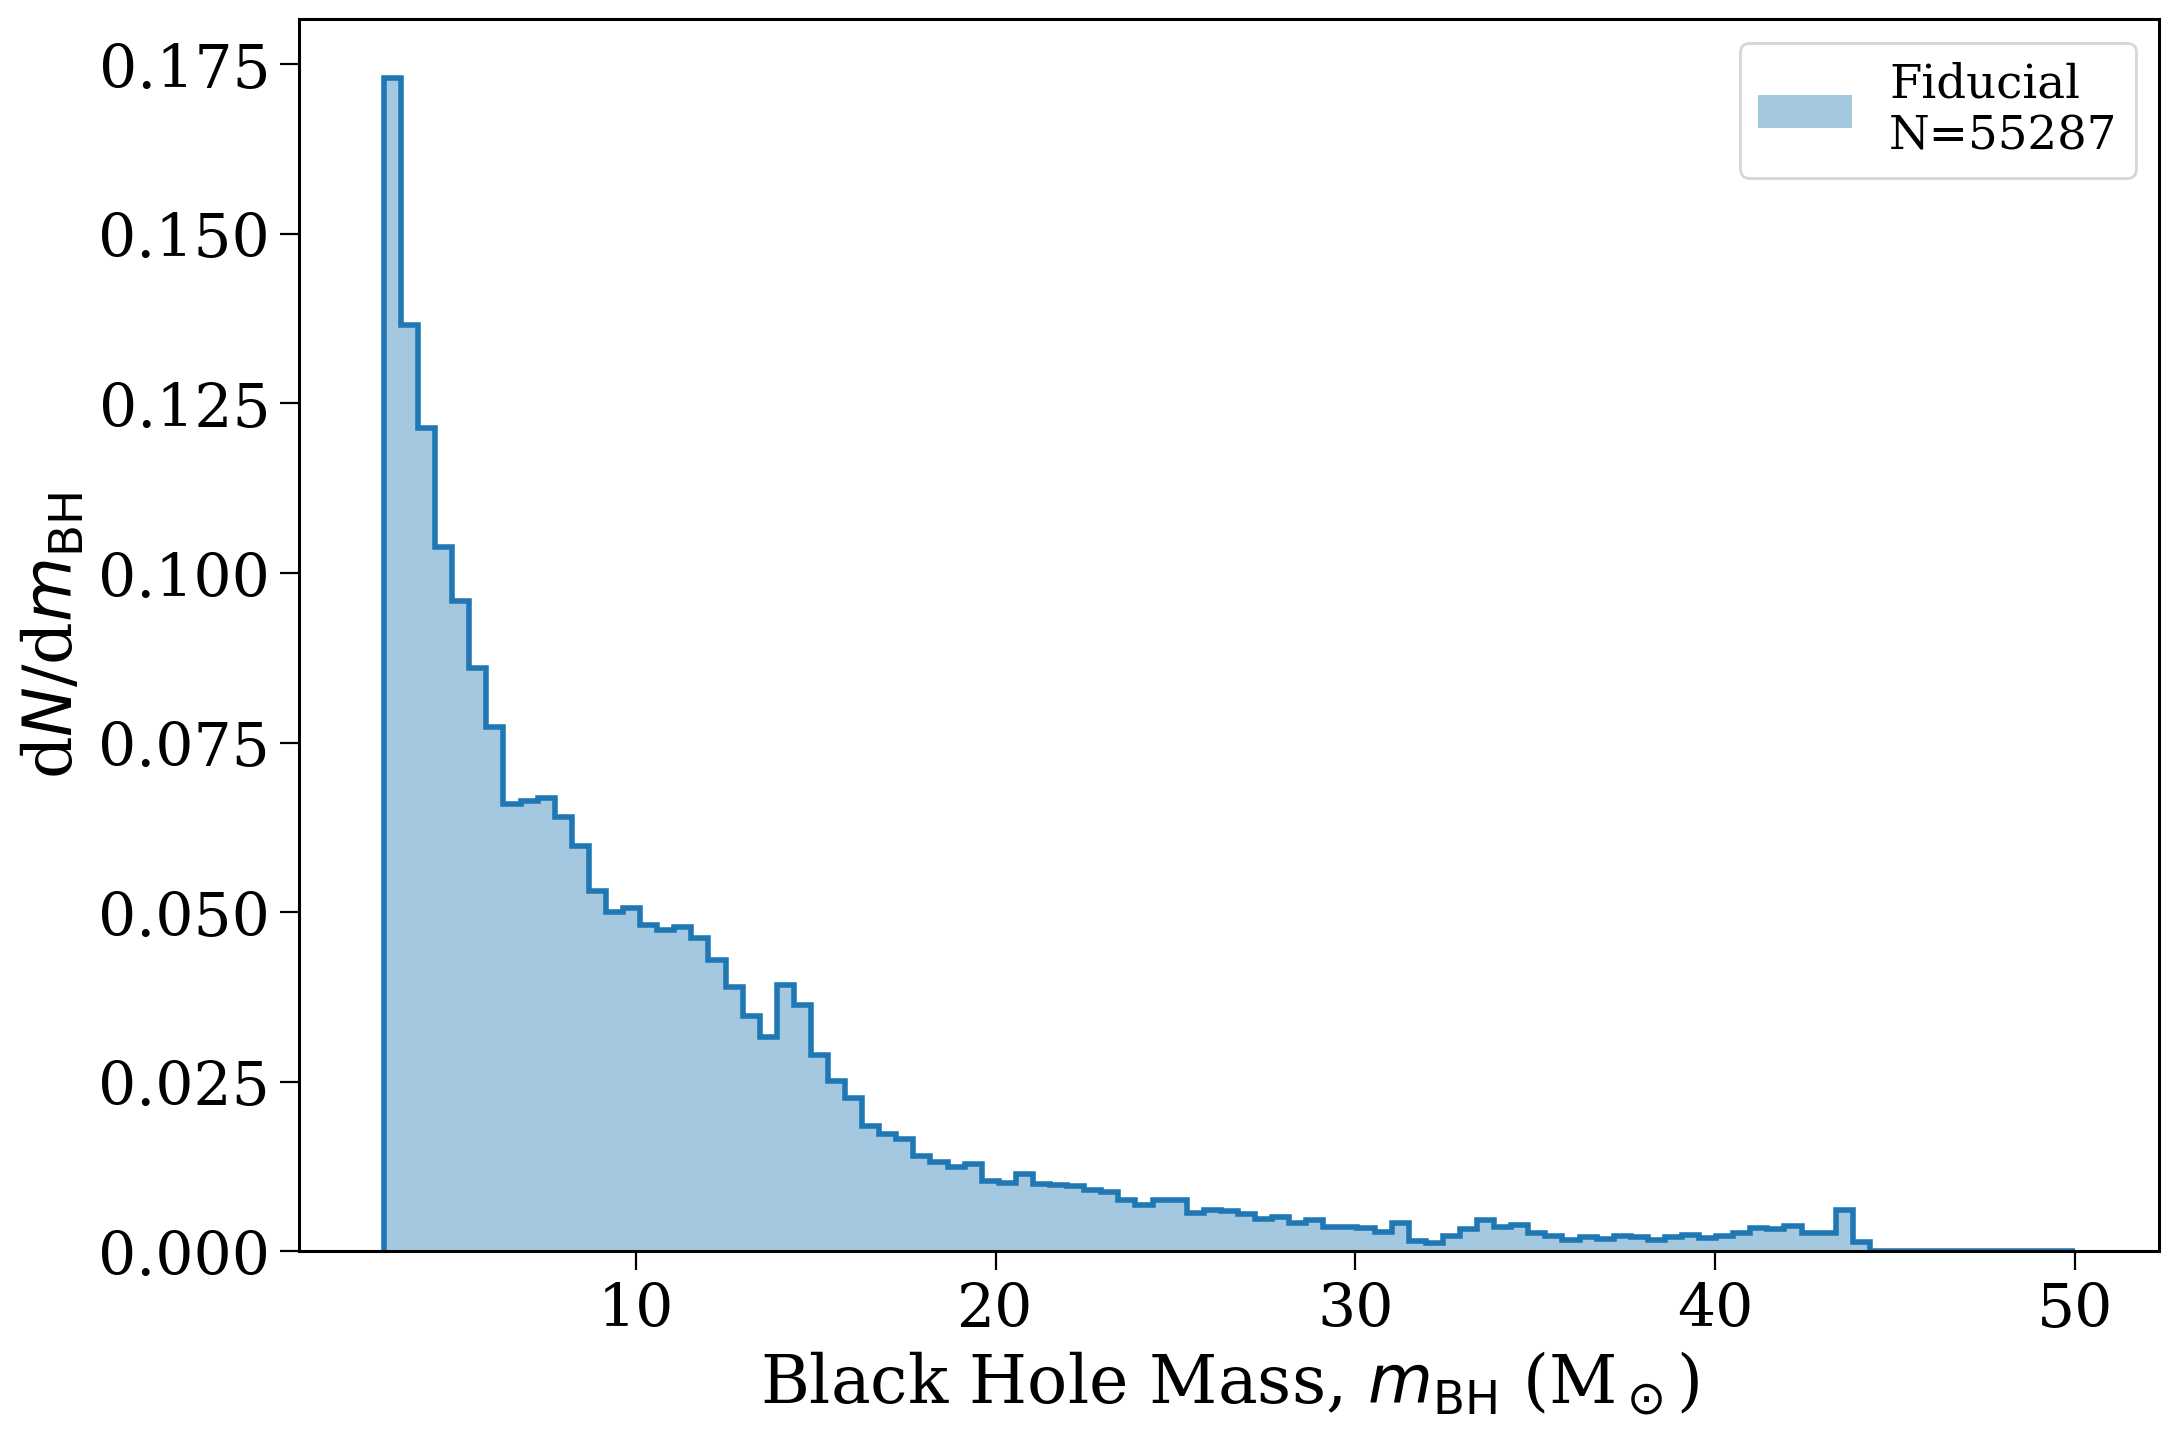

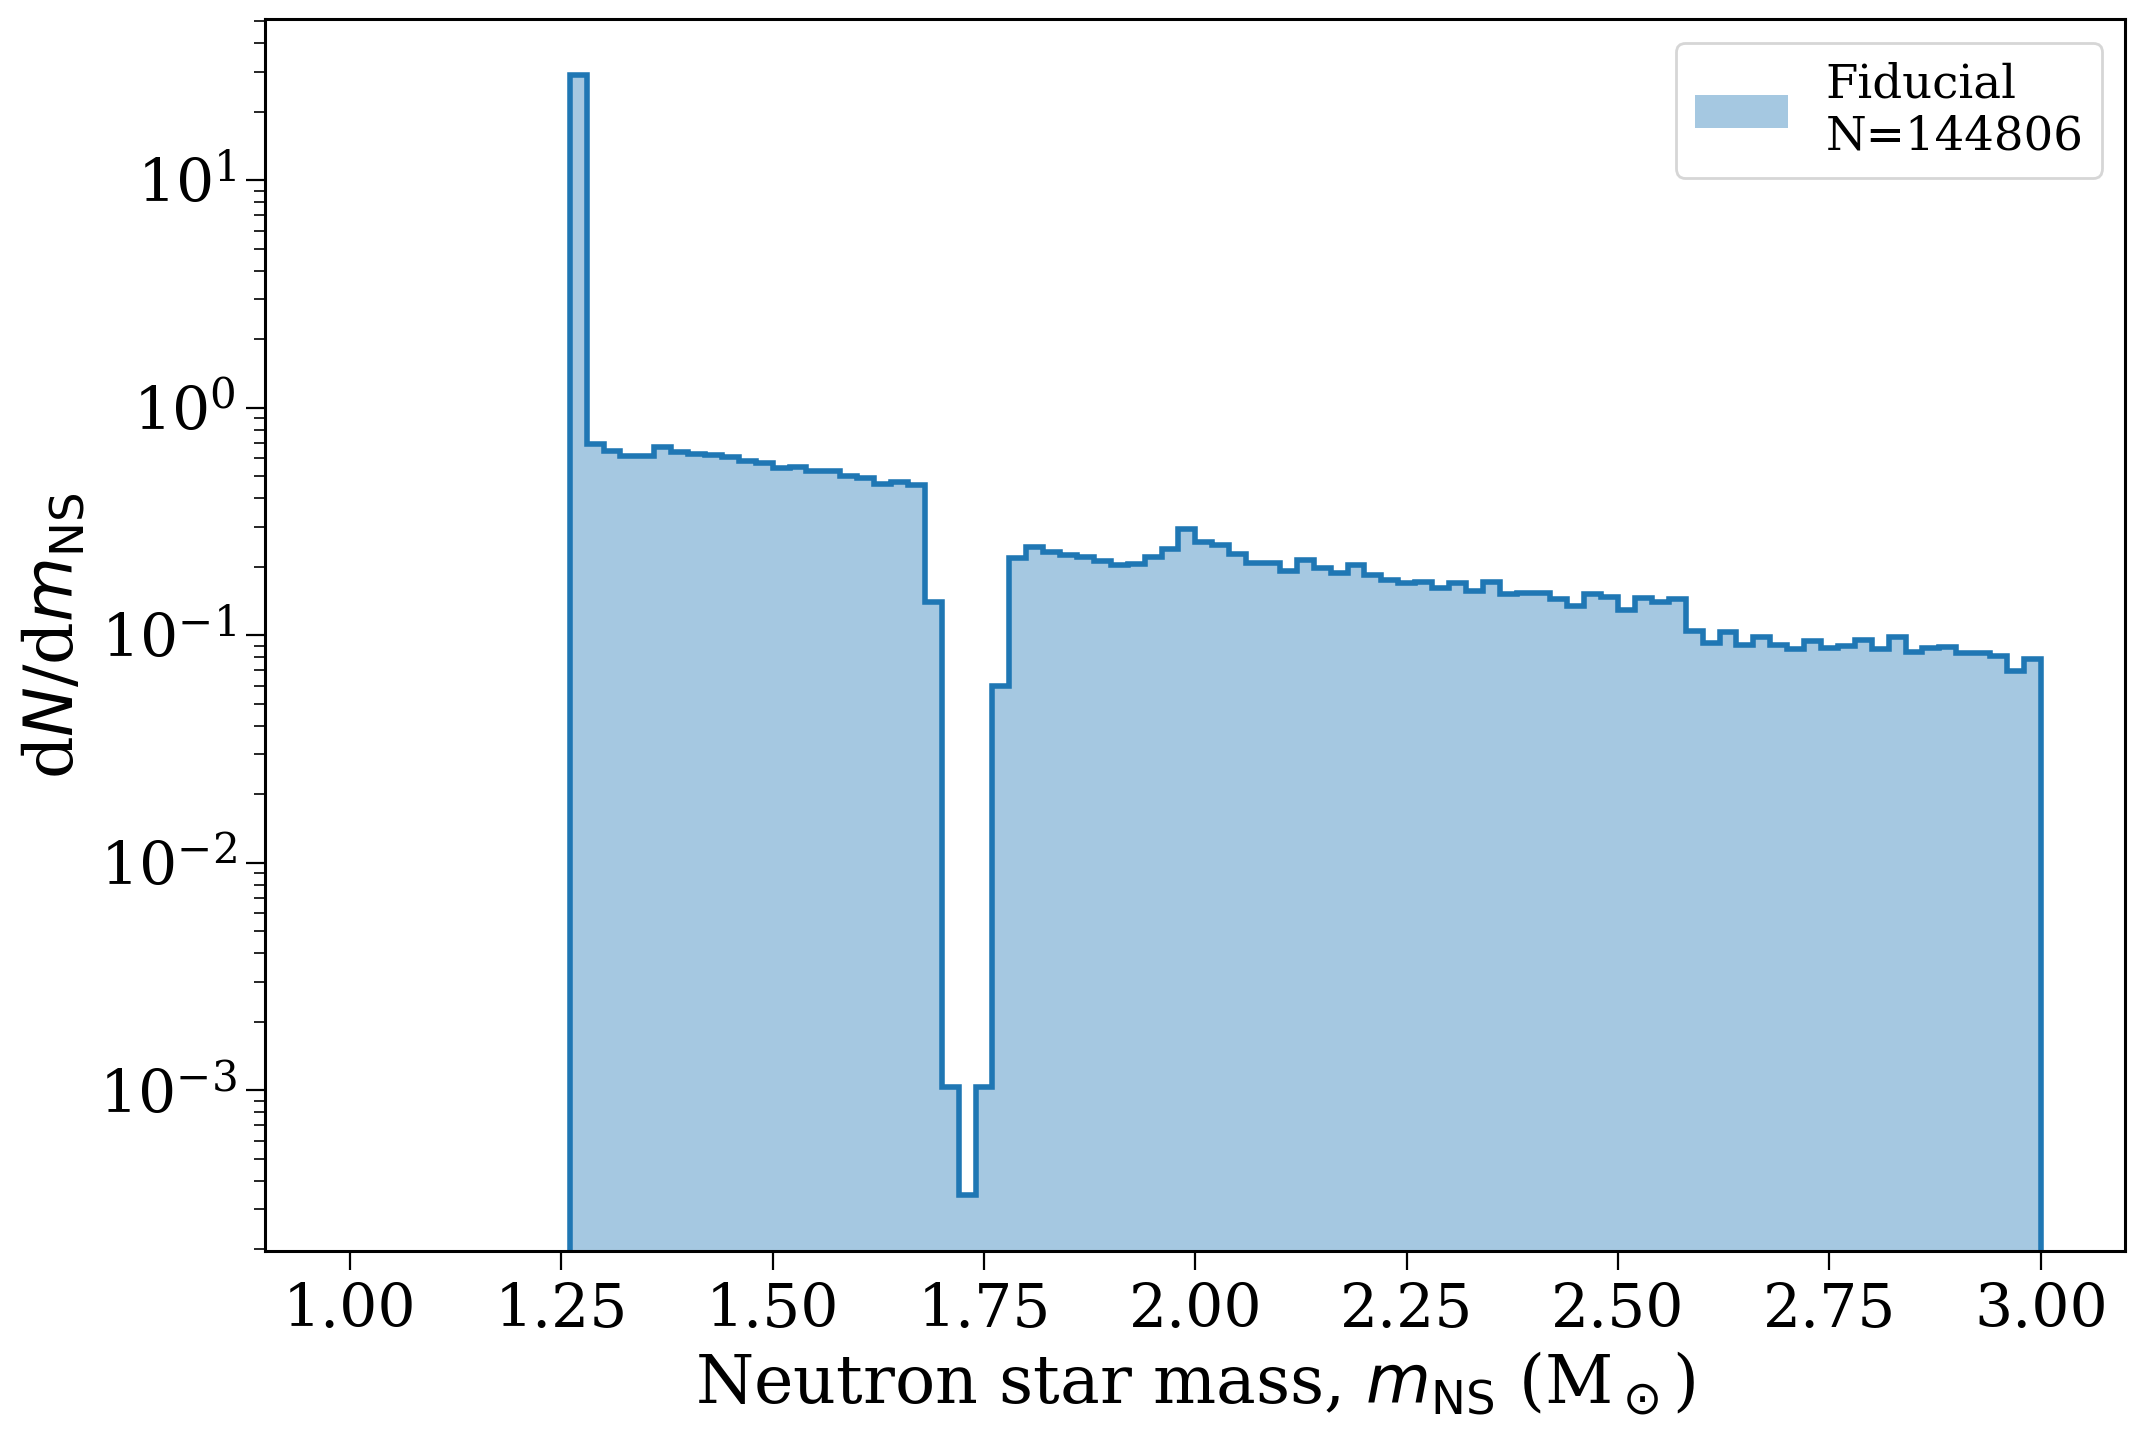

(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='Neutron star mass, $m_{\\rm NS}$ (M$_\\odot$)', ylabel='d$N$/d$m_{\\rm NS}$'>)

In [143]:
fig, ax = plotting.compare_table_quantity(
    pops=[pop],
    quantity="mass",
    kstar=14,
    bins=np.linspace(3, 50, 100),
    xlabel=r"Black Hole Mass, $m_{\rm BH}$ (M$_\odot$)",
    ylabel=r"d$N$/d$m_{\rm BH}$",
    show=False
)
plt.savefig("../plots/bh_mass_distribution.pdf", format="pdf", bbox_inches='tight')
plt.show()

plotting.compare_table_quantity(
    pops=[pop],
    quantity="mass",
    kstar=13,
    bins=np.linspace(1, 3, 101),
    xlabel=r"Neutron star mass, $m_{\rm NS}$ (M$_\odot$)",
    ylabel=r"d$N$/d$m_{\rm NS}$",
    yscale='log'
)

# Spatial vs. Mass

Larger mass objects (particularly BHs) are going to get different kicks, we should see that show up in their distribution

In [ ]:
masses = {
    "CO": np.concatenate((
        pop.final_bpp["mass_1"][pop.final_bpp["kstar_1"].isin([13, 14])],
        pop.final_bpp["mass_2"][pop.final_bpp["kstar_2"].isin([13, 14])],
    )),
    "BH": np.concatenate((
        pop.final_bpp["mass_1"][pop.final_bpp["kstar_1"] == 14],
        pop.final_bpp["mass_2"][pop.final_bpp["kstar_2"] == 14],
    )),
    "NS": np.concatenate((
        pop.final_bpp["mass_1"][pop.final_bpp["kstar_1"] == 13],
        pop.final_bpp["mass_2"][pop.final_bpp["kstar_2"] == 13],
    )),
}

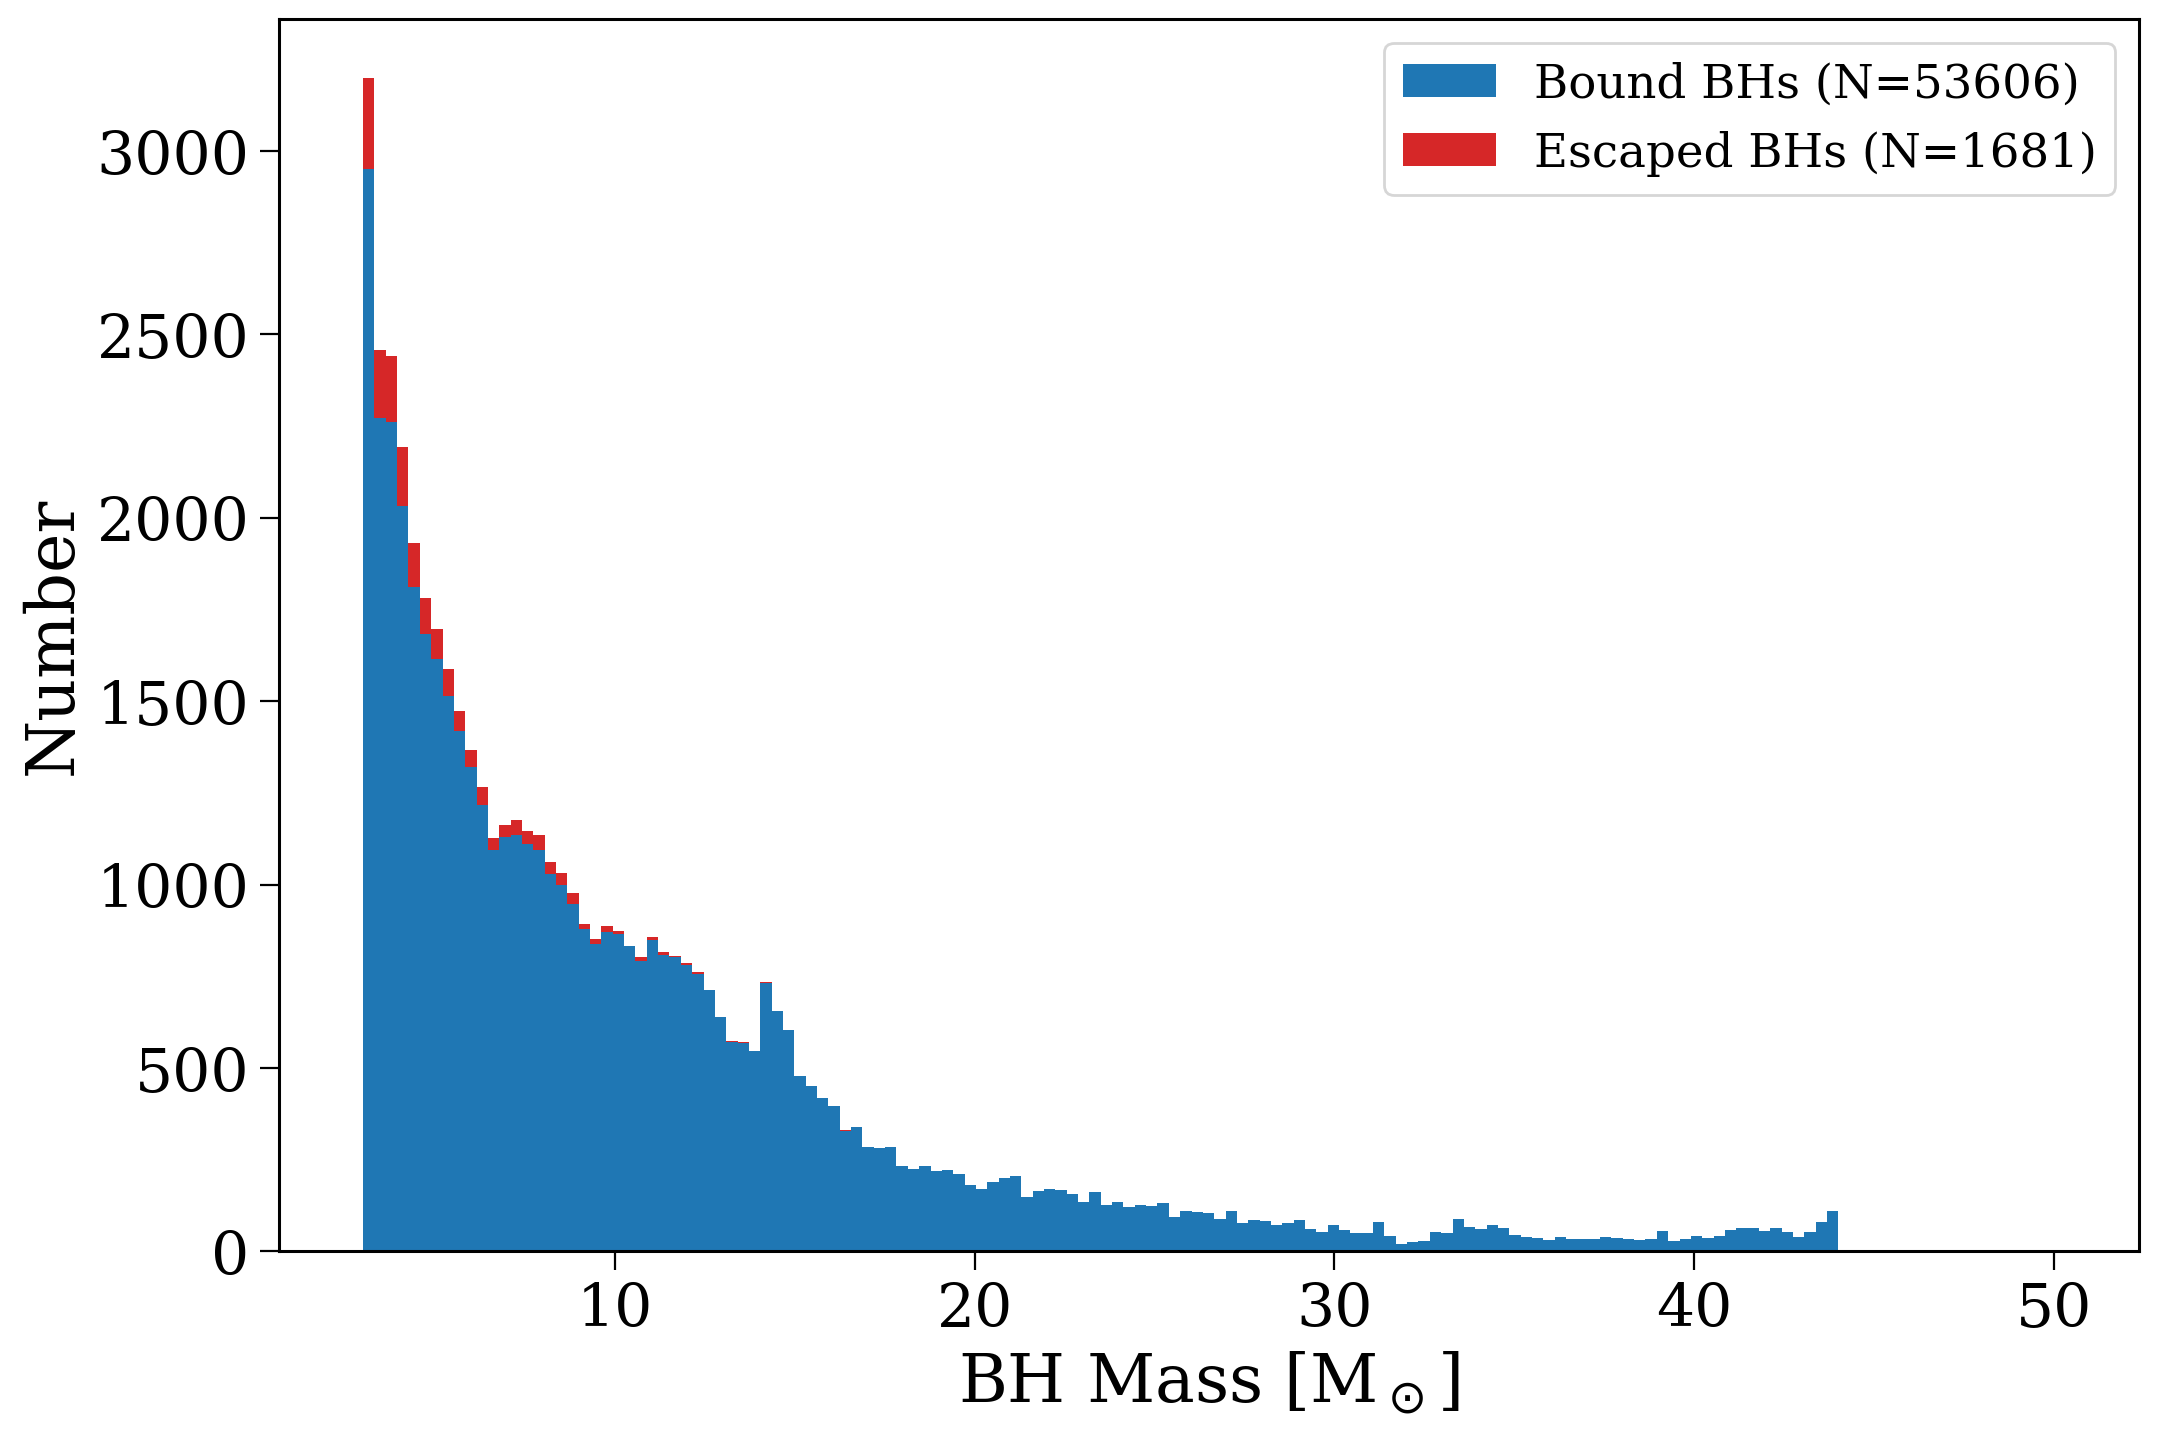

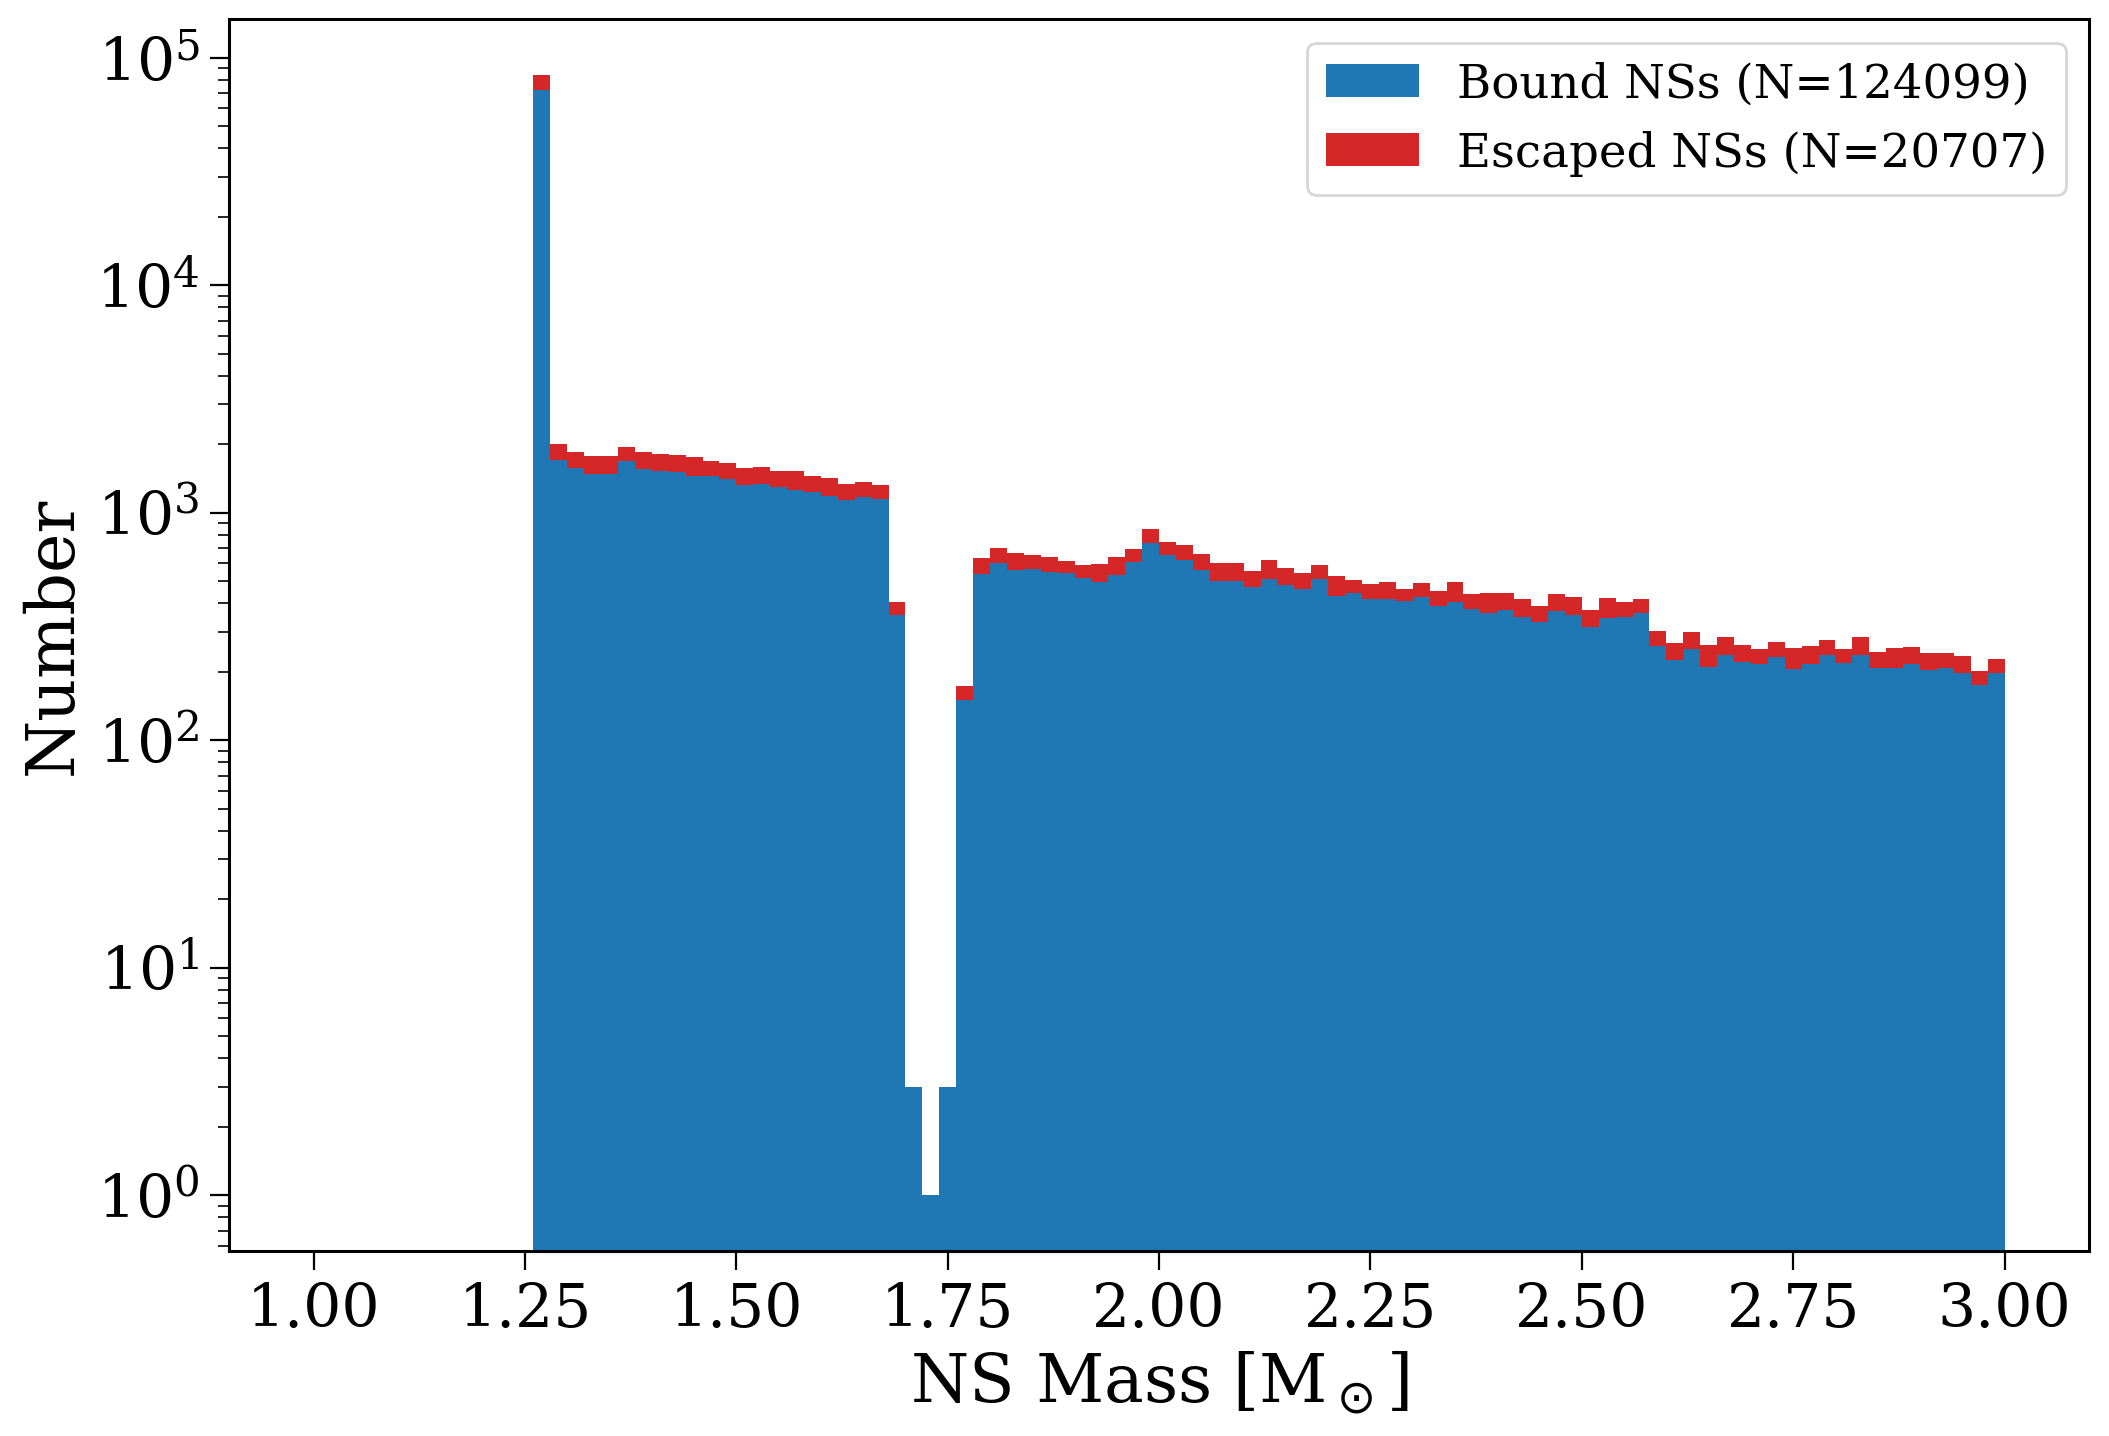

In [169]:
kinematics[pop.label]["escaped"] = {}
for co_type, bins in zip(["CO", "BH", "NS"], [None, np.linspace(3, 50, 150), np.linspace(1, 3, 101)]):

    pos = kinematics[pop.label]["pos"][co_type]
    vel = kinematics[pop.label]["vel"][co_type]

    V = np.linalg.norm(vel.to(u.km/u.s).value, axis=1)

    escaped = V >= np.sqrt(-2 * pop.galactic_potential(pos.T)).to(u.km / u.s).value

    kinematics[pop.label]["escaped"][co_type] = escaped

    if co_type == "CO":
        continue

    fig, ax = plt.subplots()

    stacked_data = [masses[co_type][~escaped], masses[co_type][escaped]]
    ax.hist(
        stacked_data,
        bins=bins,
        color=["tab:blue", "tab:red"],
        label=[f'Bound {co_type}s (N={np.sum(~escaped)})', f'Escaped {co_type}s (N={np.sum(escaped)})'],
        stacked=True,
    )

    plt.legend()

    ax.set(
        xlabel=f'{co_type} Mass [M$_\odot$]',
        ylabel='Number',
        yscale='log' if co_type == "NS" else 'linear',
    )

    plt.show()

## Stats

In [ ]:
average_escaped_BH_mass = np.mean(masses["BH"][kinematics[pop.label]["escaped"]["BH"]])
average_bound_BH_mass = np.mean(masses["BH"][~kinematics[pop.label]["escaped"]["BH"]])

In [ ]:
avg_bound_BH_close_to_disc = np.mean(masses["BH"][(
    ~kinematics[pop.label]["escaped"]["BH"] &
    (abs(kinematics[pop.label]["pos"]["BH"][:, 2].to(u.kpc).value) < 1)
)])

avg_bound_BH_far_from_disc = np.mean(masses["BH"][(
    ~kinematics[pop.label]["escaped"]["BH"] &
    (abs(kinematics[pop.label]["pos"]["BH"][:, 2].to(u.kpc).value) >= 1)
)])

In [104]:
print("Average BH masses:")
print(f"  Escaped: {average_escaped_BH_mass:.1f} Msun")
print(f"  Bound:   {average_bound_BH_mass:.1f} Msun")
print(f"    Close to disc (<1 kpc):  {avg_bound_BH_close_to_disc:.1f} Msun")
print(f"    Far from disc (>=1 kpc): {avg_bound_BH_far_from_disc:.1f} Msun")

Average BH masses:
  Escaped: 5.2 Msun
  Bound:   10.8 Msun
    Close to disc (<1 kpc):  12.1 Msun
    Far from disc (>=1 kpc): 7.9 Msun


In [105]:
# convert the above print statements to a LaTeX table
print("\nLaTeX table:")
print(r"\begin{tabular}{l c}")
print(r"  \hline")
print(r"  Population & Average BH Mass (M$_\odot$) \\")
print(r"  \hline")
print(f"  Escaped & {average_escaped_BH_mass:.1f} \\")
print(f"  Bound & {average_bound_BH_mass:.1f} \\")
print(f"  \quad Close to disc (<1 kpc) & {avg_bound_BH_close_to_disc:.1f} \\")
print(f"  \quad Far from disc (>=1 kpc) & {avg_bound_BH_far_from_disc:.1f} \\")
print(r"  \hline")
print(r"\end{tabular}")


LaTeX table:
\begin{tabular}{l c}
  \hline
  Population & Average BH Mass (M$_\odot$) \\
  \hline
  Escaped & 5.2 \
  Bound & 10.8 \
  \quad Close to disc (<1 kpc) & 12.1 \
  \quad Far from disc (>=1 kpc) & 7.9 \
  \hline
\end{tabular}


# Progentiors

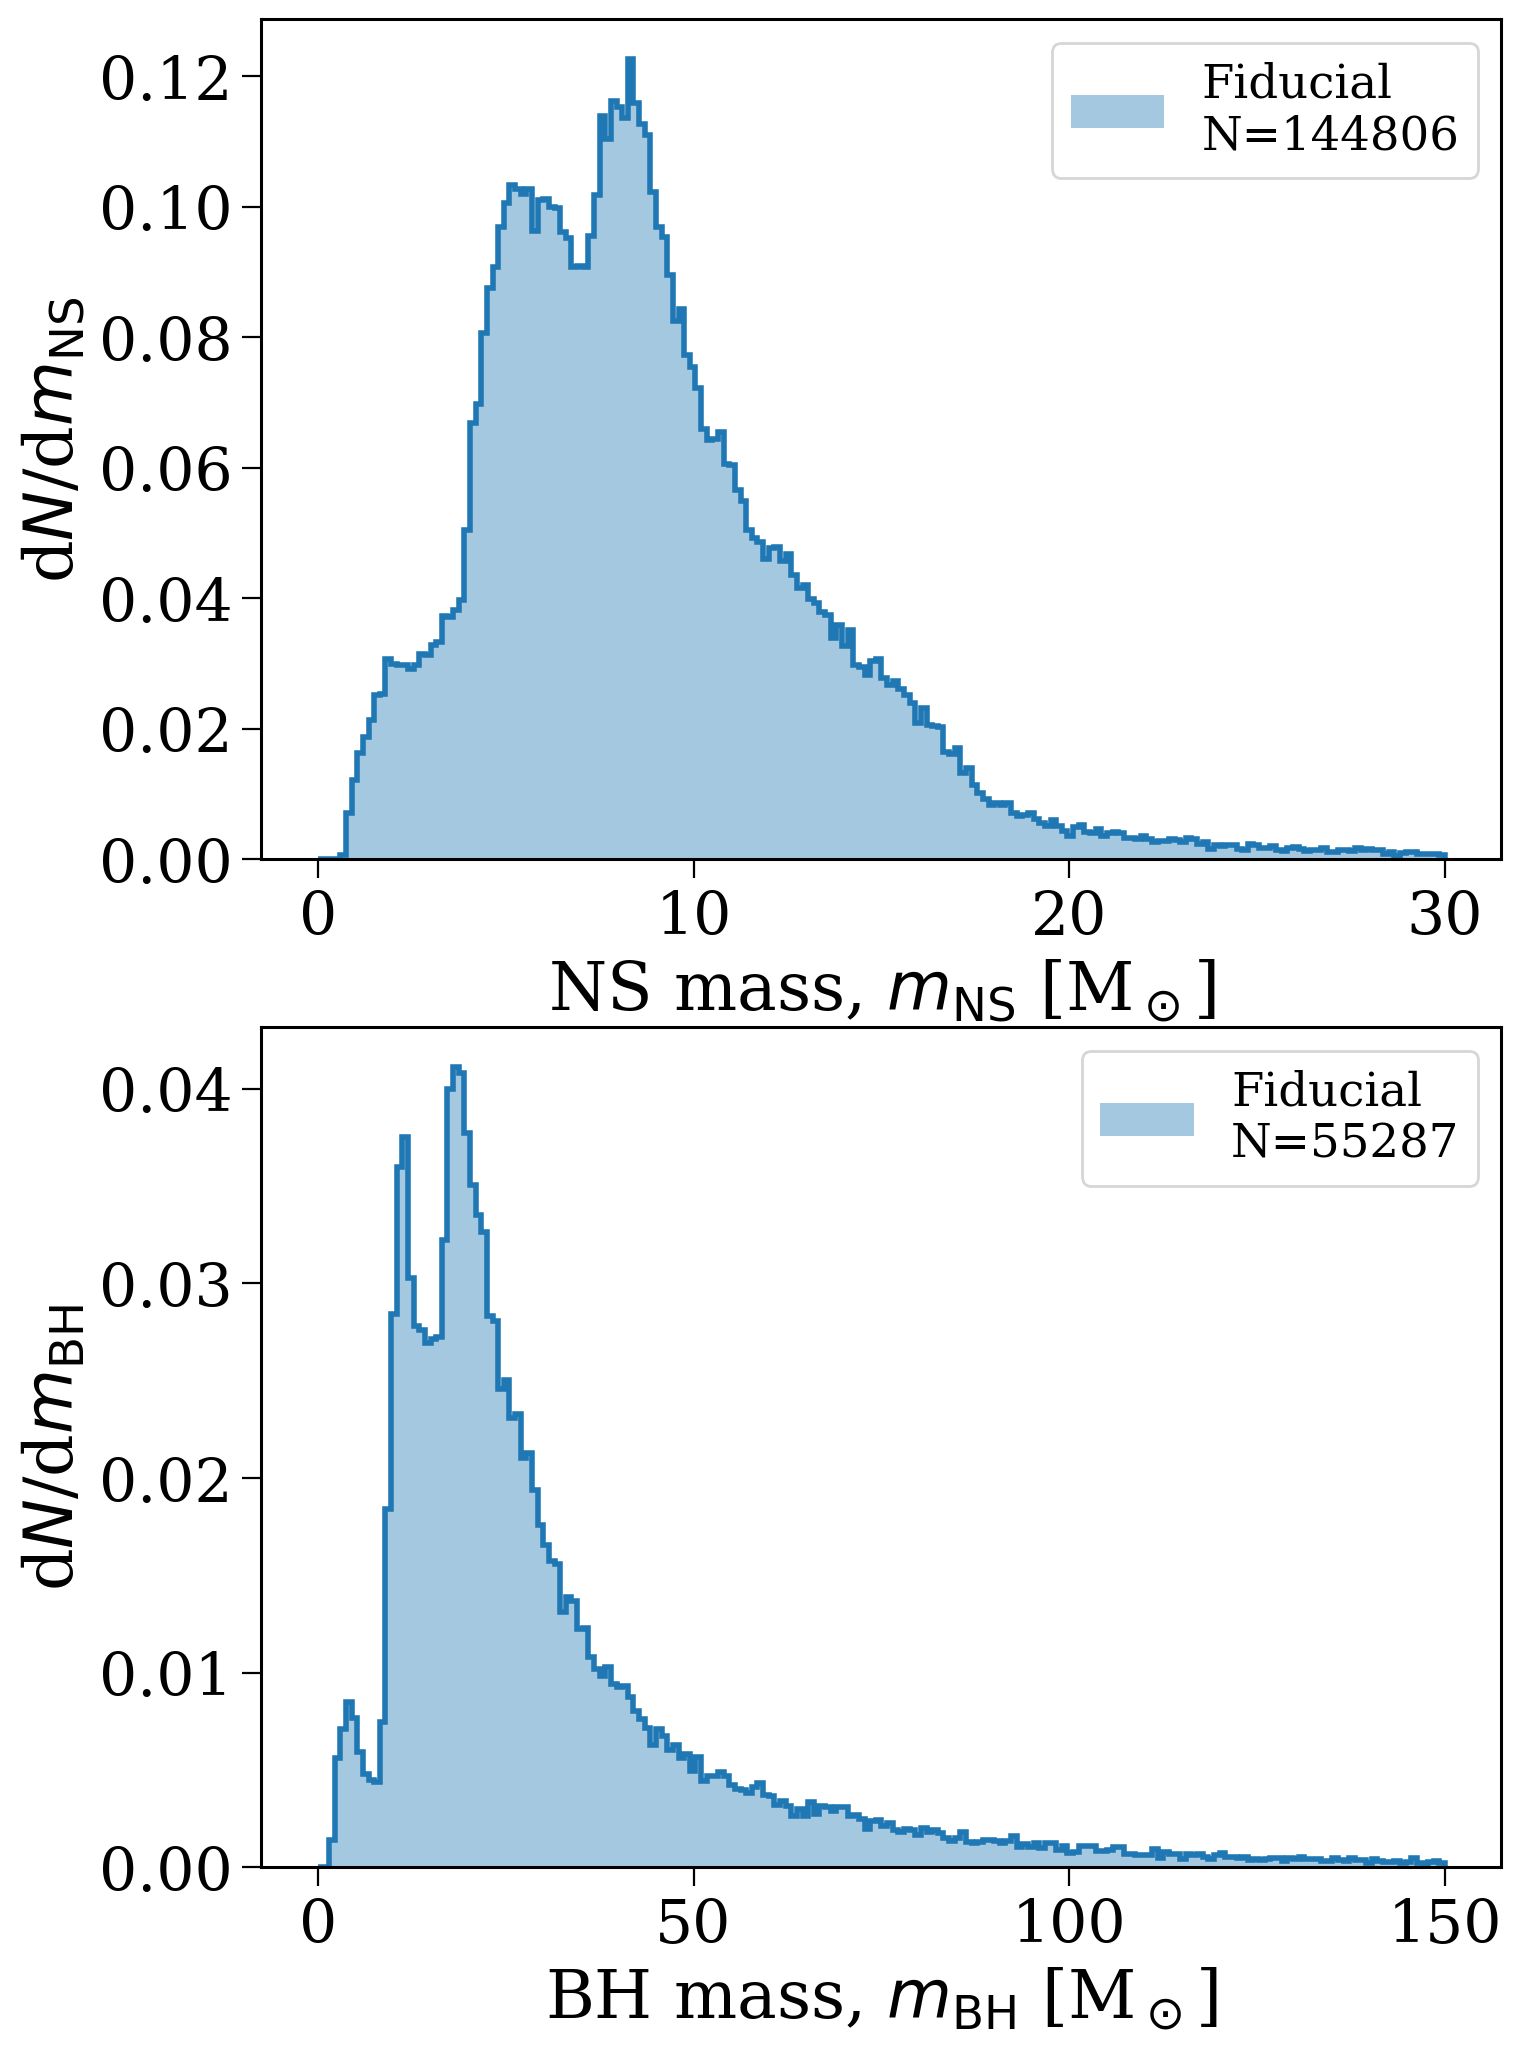

In [155]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.linspace(0, 30, 201), np.linspace(0, 150, 201)]):
    plotting.compare_table_quantity(
        pops=[pop],
        table_name="initC",
        quantity="mass",
        kstar=kstar,
        bins=bins,
        xlabel=f"{co_type} mass, $m_{{\\rm {co_type}}}$ [M$_\odot$]",
        ylabel=f"d$N$/d$m_{{\\rm {co_type}}}$",
        density=True,
        ax=ax,
        fig=fig,
        show=False
    )

plt.savefig("../plots/progenitor_masses.pdf", format="pdf", bbox_inches='tight')
plt.show()

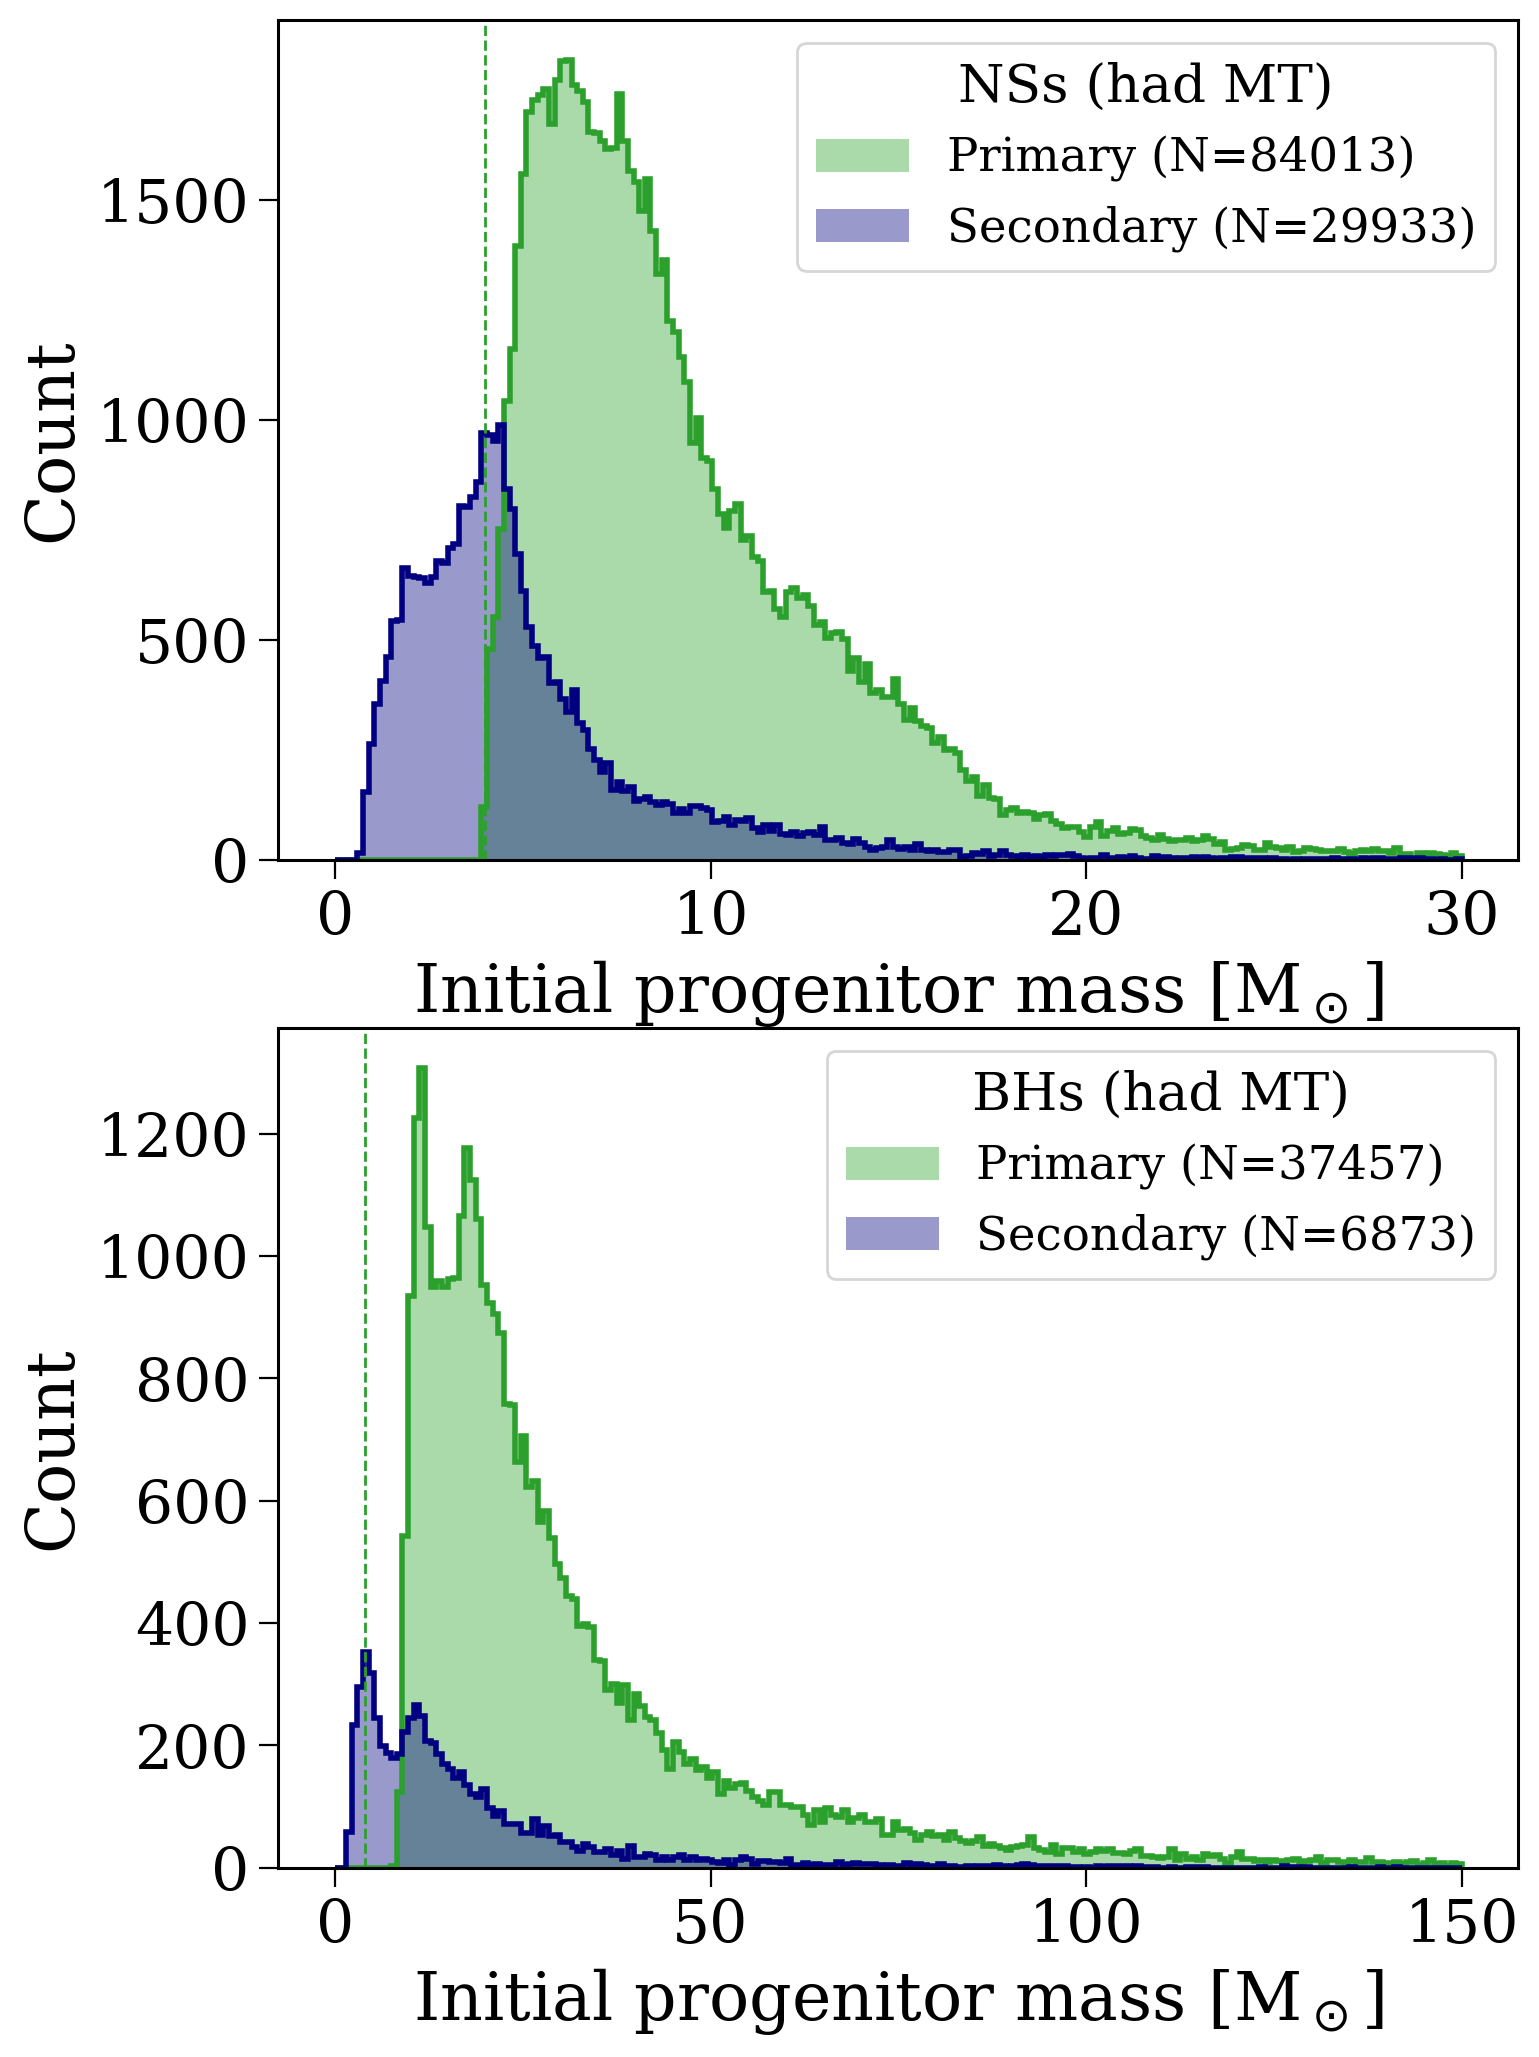

In [156]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.linspace(0, 30, 201), np.linspace(0, 150, 201)]):
    for comp, colour, label in zip(["1", "2"], ["tab:green", "navy"], ["Primary", "Secondary"]):
        experienced_mt = pop.bpp[pop.bpp["evol_type"] == 3]["bin_num"]
        experienced_ce = pop.bpp[pop.bpp["evol_type"] == 7]["bin_num"]

        init_masses = pop.initC[f"mass_{comp}"][(
            (pop.final_bpp[f"kstar_{comp}"] == kstar)
            & (pop.final_bpp["bin_num"].isin(experienced_mt))
            # & ~(pop.final_bpp["bin_num"].isin(experienced_ce))
        )]

        ax.hist(init_masses, bins=bins, histtype='step', lw=2, color=colour)
        ax.hist(init_masses, bins=bins, alpha=0.4, color=colour,
                label=f"{label} (N={len(init_masses)})")
        
    ax.axvline(4, color="tab:green", ls='--', lw=1)

    ax.set(
        xlabel=f"Initial progenitor mass [M$_\odot$]",
        ylabel="Count"
    )
    ax.legend(title=f"{co_type}s (had MT)")

plt.savefig("../plots/progenitor_masses_mt.pdf", format="pdf", bbox_inches='tight')
plt.show()

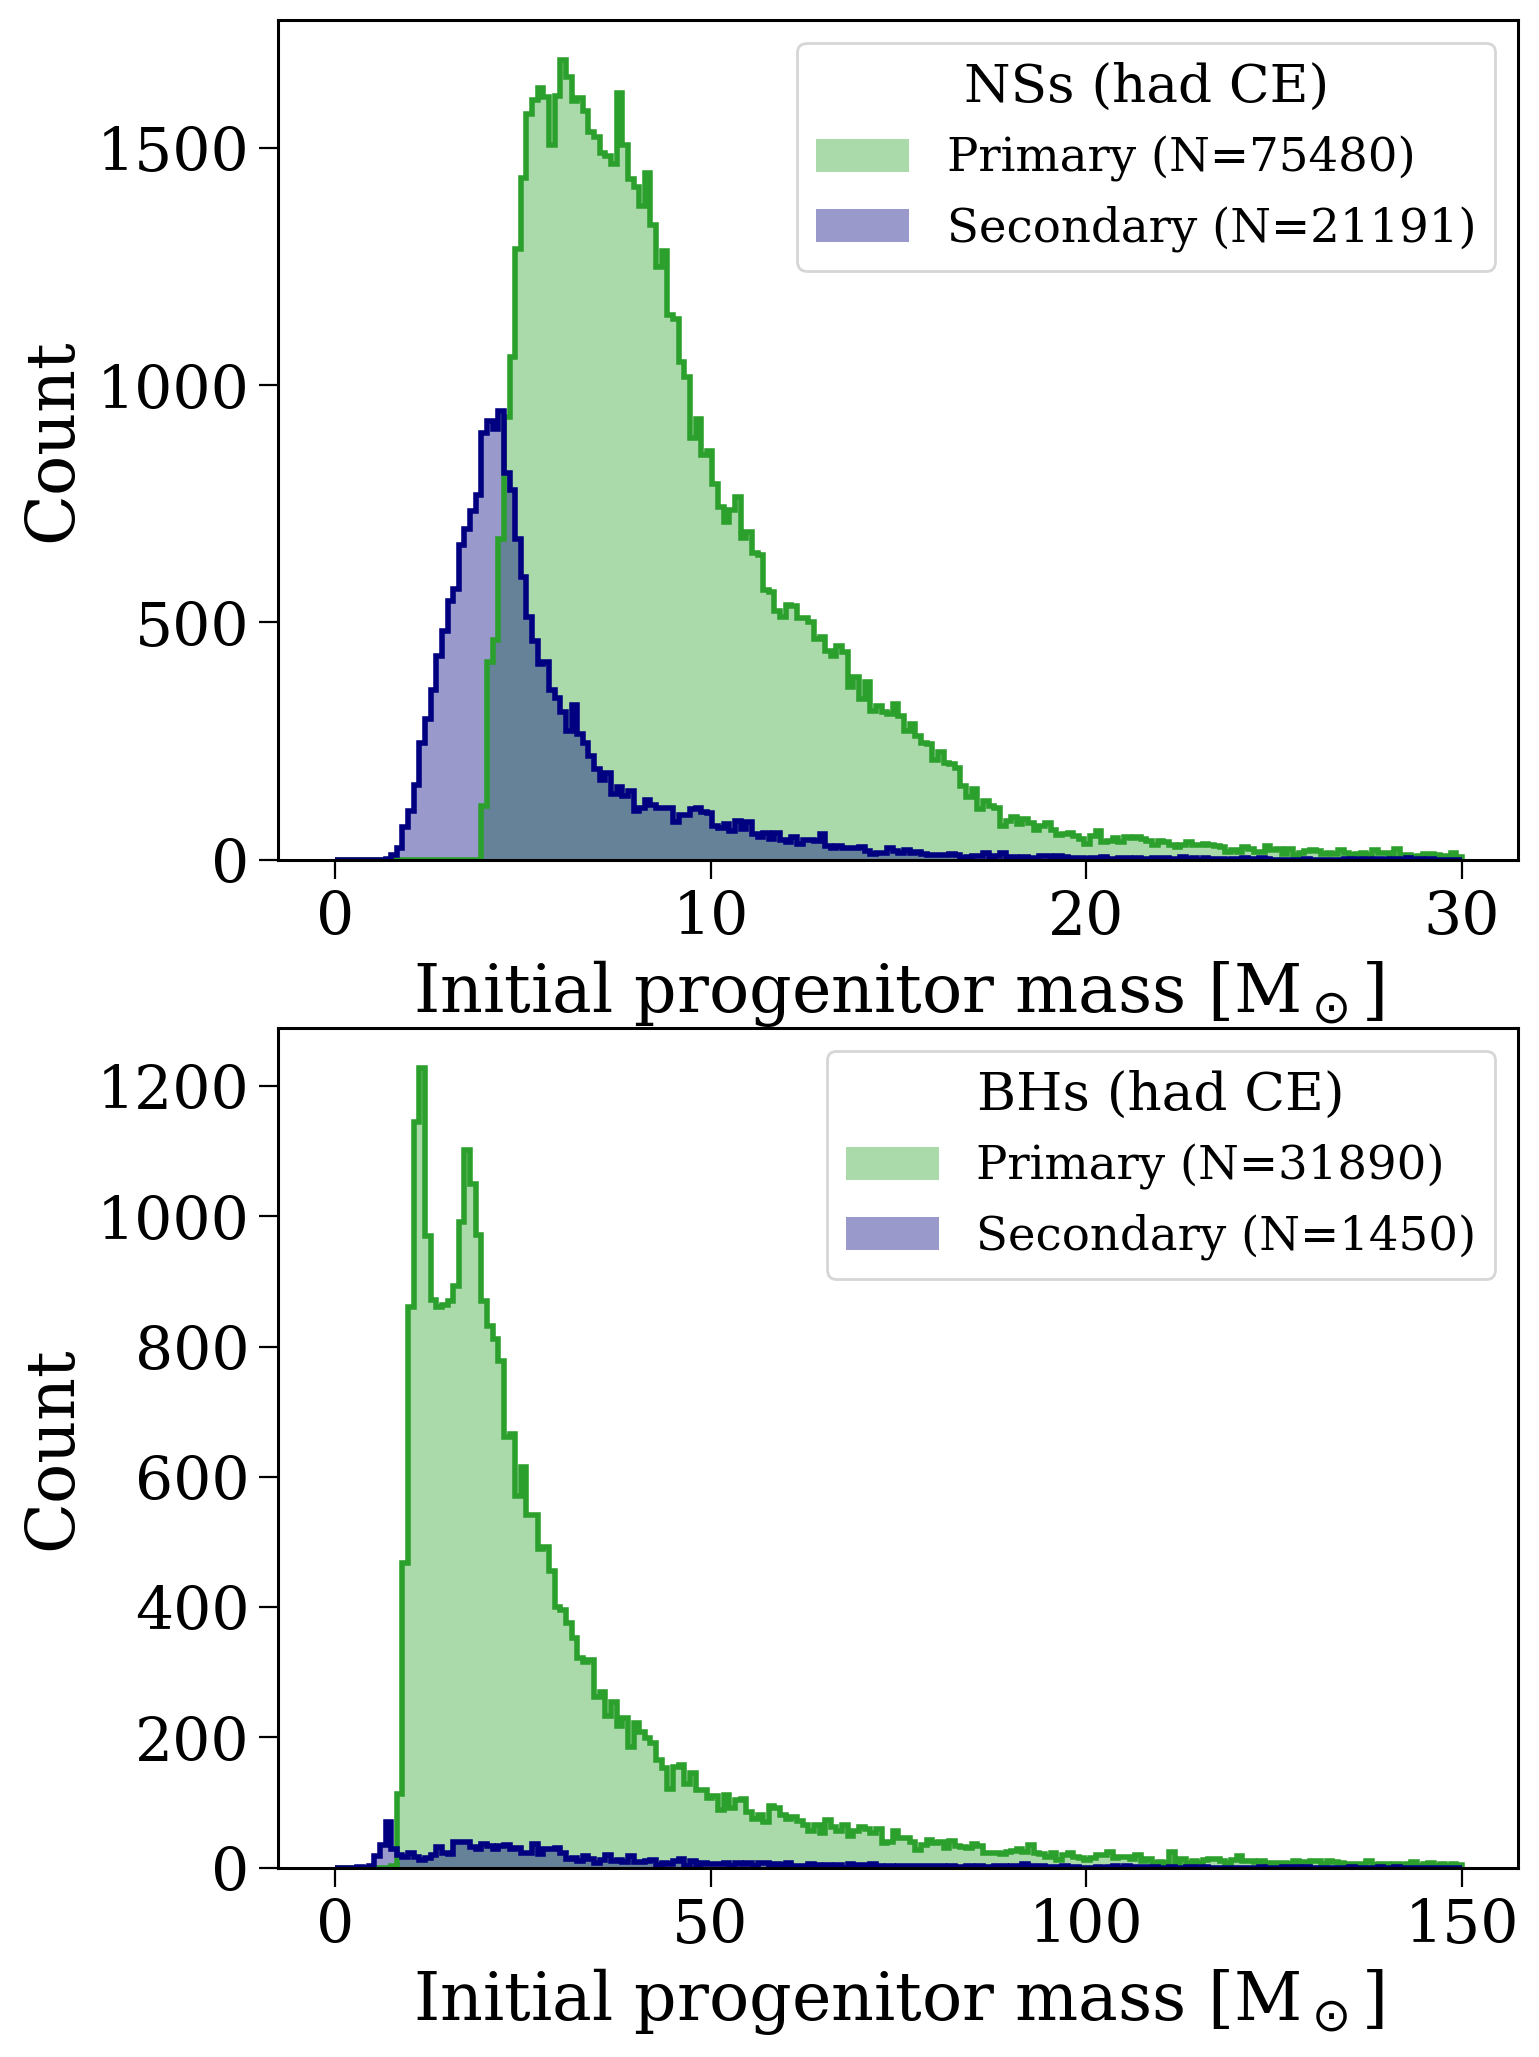

In [158]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.linspace(0, 30, 201), np.linspace(0, 150, 201)]):
    for comp, colour, label in zip(["1", "2"], ["tab:green", "navy"], ["Primary", "Secondary"]):
        experienced_mt = pop.bpp[pop.bpp["evol_type"] == 3]["bin_num"]
        experienced_ce = pop.bpp[pop.bpp["evol_type"] == 7]["bin_num"]

        init_masses = pop.initC[f"mass_{comp}"][(
            (pop.final_bpp[f"kstar_{comp}"] == kstar)
            & (pop.final_bpp["bin_num"].isin(experienced_mt))
            & (pop.final_bpp["bin_num"].isin(experienced_ce))
        )]

        ax.hist(init_masses, bins=bins, histtype='step', lw=2, color=colour)
        ax.hist(init_masses, bins=bins, alpha=0.4, color=colour,
                label=f"{label} (N={len(init_masses)})")

    ax.set(
        xlabel=f"Initial progenitor mass [M$_\odot$]",
        ylabel="Count"
    )
    ax.legend(title=f"{co_type}s (had CE)")

plt.savefig("../plots/progenitor_masses_ce.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Nearest COs

In [160]:
for co_type in ["CO", "NS", "BH"]:
    co_pos = kinematics["Fiducial"]["pos"][co_type]

    # count how many COs are within a torus of major radius 8kpc and minor radius 0.2kpc
    # shape of co_pos is (N, 3), in galactocentric cartesian
    R = np.sqrt(co_pos[:, 0]**2 + co_pos[:, 1]**2).to(u.kpc).value
    z = co_pos[:, 2].to(u.kpc).value
    torus_mask = ((R - 8)**2 + z**2) <= 0.2**2
    n_in_torus = torus_mask.sum()
    n_total = len(co_pos)

    # density of COs in torus in pc^-3
    torus_volume = 2 * np.pi**2 * 8 * 0.2**2 * u.kpc**3
    co_density = n_in_torus / torus_volume.to(u.pc**3) * scale_up
    one_per_volume = 1 / co_density

    # find probable distance to nearest assuming a sphere
    nearest_distance = (3 / (4 * np.pi * co_density))**(1/3)
    print(f"Probable distance to the nearest {co_type} is {nearest_distance:.2f}")

Probable distance to the nearest CO is 8.43 pc
Probable distance to the nearest NS is 10.03 pc
Probable distance to the nearest BH is 11.38 pc


# Double compact objects with a NS/BH

## At present day

In [166]:
pop

<Population - 179656 evolved systems - galactic_potential=MilkyWayPotential2022, sfh_model=StarFormationHistory>

In [200]:
ns_bin_nums = np.concatenate((
    pop.final_bpp["bin_num"][pop.final_bpp["kstar_1"] == 13],
    pop.final_bpp["bin_num"][pop.final_bpp["kstar_2"] == 13],
))
bh_bin_nums = np.concatenate((
    pop.final_bpp["bin_num"][pop.final_bpp["kstar_1"] == 14],
    pop.final_bpp["bin_num"][pop.final_bpp["kstar_2"] == 14],
))
bin_nums = np.concatenate((ns_bin_nums, bh_bin_nums))

ns_sep = np.concatenate((
    pop.final_bpp["sep"][pop.final_bpp["kstar_1"] == 13],
    pop.final_bpp["sep"][pop.final_bpp["kstar_2"] == 13],
))
bh_sep = np.concatenate((
    pop.final_bpp["sep"][pop.final_bpp["kstar_1"] == 14],
    pop.final_bpp["sep"][pop.final_bpp["kstar_2"] == 14],
))
separations = np.concatenate((ns_sep, bh_sep))

In [201]:
len(np.unique(bin_nums[separations > 0]))

1387

In [202]:
len(np.unique(bin_nums[((separations > 0) & (kinematics["Fiducial"]["escaped"]["CO"]))]))

0

In [244]:
reload(helpers)

<module 'helpers' from '/mnt/home/twagg/projects/underworld/analysis/../src/helpers.py'>

In [256]:
reload(helpers)
underworld_binaries = helpers.get_underworld_binaries([pop], verbose=True)["Fiducial"]

Fiducial Underworld Binaries (scale up by 3308x):

  BH-BH:     1041  	3.4e+06 (scaled)
  BH-NS:     37  	1.2e+05 (scaled)
  BH-WD:     167  	5.5e+05 (scaled)
  BH-Star:   2  	6.6e+03 (scaled)

  NS-NS:     2  	6.6e+03 (scaled)
  NS-WD:     121  	4.0e+05 (scaled)
  NS-Star:   15  	5.0e+04 (scaled)
-----------


In [287]:
print(f"Scale everything up by a factor of ~{scale_up:.0f}x\n")
# print the number of bound binaries with a CO and their kstars
for label, table in underworld_binaries.items():
    n_binaries = len(table)
    avg_bh_mass = np.mean(np.concatenate((
        table["mass_1"][table["kstar_1"] == 14],
        table["mass_2"][table["kstar_2"] == 14],
    ))) if (table["kstar_1"] == 14).any() or (table["kstar_2"] == 14).any() else 0
    avg_ns_mass = np.mean(np.concatenate((
        table["mass_1"][table["kstar_1"] == 13],
        table["mass_2"][table["kstar_2"] == 13],
    ))) if (table["kstar_1"] == 13).any() or (table["kstar_2"] == 13).any() else 0

    avg_sep = np.mean(table["sep"])
    print(f"  {label}:{' ' * (9 - len(label))} {len(table):.0f}  \t{len(table) * scale_up:.1e} (scaled)\t{avg_bh_mass:.1f} Msun \t{avg_ns_mass:.1f} Msun \t {avg_sep:.1e} Rsun")
    if label == "BH-Star":
        print()

Scale everything up by a factor of ~3308x

  BH-BH:     1041  	3.4e+06 (scaled)	19.5 Msun 	0.0 Msun 	 7.7e+04 Rsun
  BH-NS:     37  	1.2e+05 (scaled)	13.3 Msun 	2.0 Msun 	 5.4e+02 Rsun
  BH-WD:     167  	5.5e+05 (scaled)	9.1 Msun 	0.0 Msun 	 3.9e+04 Rsun
  BH-Star:   2  	6.6e+03 (scaled)	3.2 Msun 	0.0 Msun 	 3.4e+00 Rsun

  NS-NS:     2  	6.6e+03 (scaled)	0.0 Msun 	1.7 Msun 	 4.1e+01 Rsun
  NS-WD:     121  	4.0e+05 (scaled)	0.0 Msun 	1.8 Msun 	 1.6e+04 Rsun
  NS-Star:   15  	5.0e+04 (scaled)	0.0 Msun 	2.1 Msun 	 3.7e+01 Rsun


In [285]:
# convert the above print statements to a LaTeX table
print(r"\begin{tabular}{l c c c c}")
print(r"  \hline")
print(r"  Population & $N_{\rm sim}$ & $N_{\rm MW}$ & $\langle m_{\rm CO} \rangle$ (M$_\odot$) & $\langle a \rangle$ (R$_\odot$) \\")
print(r"  \hline")
for label, table in underworld_binaries.items():
    n_binaries = len(table)
    avg_bh_mass = np.mean(np.concatenate((
        table["mass_1"][table["kstar_1"] == 14],
        table["mass_2"][table["kstar_2"] == 14],
    ))) if (table["kstar_1"] == 14).any() or (table["kstar_2"] == 14).any() else 0
    avg_ns_mass = np.mean(np.concatenate((
        table["mass_1"][table["kstar_1"] == 13],
        table["mass_2"][table["kstar_2"] == 13],
    ))) if (table["kstar_1"] == 13).any() or (table["kstar_2"] == 13).any() else 0

    avg_co_mass = f"{avg_bh_mass:.1f} / {avg_ns_mass:.1f}" if (avg_bh_mass > 0 and avg_ns_mass > 0) else (
        f"{avg_bh_mass:.1f}" if avg_bh_mass > 0 else (f"{avg_ns_mass:.1f}" if avg_ns_mass > 0 else "-")
    )

    avg_sep = np.mean(table["sep"])

    row = f"  {label} & ${len(table):.0f}$ & ${len(table) * scale_up:.1e}}}$ & ${avg_co_mass}$ & ${avg_sep:.1e}}}$ \\\\"
    row = row.replace('e+0', r'\times 10^{')
    row = row.replace('0.0', '-')
    print(row)

    # replace e+0x with "\times 10^{x}"


    if label == "BH-Star":
        print(r"  \hline")
print(r"\end{tabular}")

\begin{tabular}{l c c c c}
  \hline
  Population & $N_{\rm sim}$ & $N_{\rm MW}$ & $\langle m_{\rm CO} \rangle$ (M$_\odot$) & $\langle a \rangle$ (R$_\odot$) \\
  \hline
  BH-BH & $1041$ & $3.4\times 10^{6}$ & $19.5$ & $7.7\times 10^{4}$ \\
  BH-NS & $37$ & $1.2\times 10^{5}$ & $13.3 / 2.0$ & $5.4\times 10^{2}$ \\
  BH-WD & $167$ & $5.5\times 10^{5}$ & $9.1$ & $3.9\times 10^{4}$ \\
  BH-Star & $2$ & $6.6\times 10^{3}$ & $3.2$ & $3.4\times 10^{0}$ \\
  \hline
  NS-NS & $2$ & $6.6\times 10^{3}$ & $1.7$ & $4.1\times 10^{1}$ \\
  NS-WD & $121$ & $4.0\times 10^{5}$ & $1.8$ & $1.6\times 10^{4}$ \\
  NS-Star & $15$ & $5.0\times 10^{4}$ & $2.1$ & $3.7\times 10^{1}$ \\
\end{tabular}


## Mergers

In [215]:
bhbh_mergers = pop.bpp[(pop.bpp["evol_type"] == 3) & (
    (pop.bpp["kstar_1"] == 14) & (pop.bpp["kstar_2"] == 14)
)]
nsns_mergers = pop.bpp[(pop.bpp["evol_type"] == 3) & (
    (pop.bpp["kstar_1"] == 13) & (pop.bpp["kstar_2"] == 13)
)]
nsbh_mergers = pop.bpp[(pop.bpp["evol_type"] == 3) & (
    ((pop.bpp["kstar_1"] == 13) & (pop.bpp["kstar_2"] == 14)) |
    ((pop.bpp["kstar_1"] == 14) & (pop.bpp["kstar_2"] == 13))
)]
print(f"Estimated number of mergers in a MW-mass galaxy (minimum here would be {scale_up:.0f}):")
print(f"  BH-BH mergers: {len(bhbh_mergers) * scale_up:.0f}")
print(f"  NS-NS mergers: {len(nsns_mergers) * scale_up:.0f}")
print(f"  NS-BH mergers: {len(nsbh_mergers) * scale_up:.0f}")

Estimated number of mergers in a MW-mass galaxy (minimum here would be 3308):
  BH-BH mergers: 205072
  NS-NS mergers: 6615
  NS-BH mergers: 82690
